<a href="https://colab.research.google.com/github/dac1997/MuonLifetimeExperience/blob/main/Exp%2BBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of an exponential signal for the muon lifetime experiment

In [ ]:
# Diego Alberto Coloma Borja, 2023
#python 3

#import libraries
from random import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as spicy
from scipy import stats
from scipy.optimize import curve_fit
from IPython.display import clear_output

%matplotlib inline

#functions to fit the data using curve_fit later in the code
def full_function(x, a, tau, baseline):
   return a*np.exp(-x/tau) + baseline
def exponential(x,a,tau):
   return a*np.exp(-x/tau)
def p0_fit(x,a):
   return a

def pana_gauss(x, u , sigma):
    '''function that defines the gauss function to fit parameters
       u     - mean of the function
       sigma - standard deviation
       x.    -      input'''

    c = np.sqrt(2 * np.pi)
    return np.exp(-0.5 * ((x-u)/ sigma)**2) / sigma / c

#global variables used thorughout the execution
rebinning = 1
tau_long  = int(187/rebinning)
tau_short = int(75/rebinning)
entriesperminute   = 7.31105
baseline_perday = 0.32
week = int(entriesperminute*10080)

# Definition of the function that simulates a signal of an exponential signal

In [ ]:
#Function that simply simulates a signal
def simulation(baseline, numberofentries, create_pictures="no"):

    numberofbins              = 1878
    numberofentries_baseline  = int(numberofbins*baseline)
    numberofentries_exp       = numberofentries - numberofentries_baseline

    uniform_exp    = np.array([random() for j in range(numberofentries_exp)])
    array_exp      = list(-tau_long*rebinning*np.log(1-uniform_exp)) # array to simulate an exponetial of shape Aexp(-t/taul)
    array_baseline = list(np.random.uniform(0, numberofbins, numberofentries_baseline)) # uniform array betwee 0 and the number of bins

    total_signal = array_exp + array_baseline #put all of the values together
    #create a histogram of the total values of the signal with bins of width 1
    counts_signal, bines , _ = plt.hist(total_signal,
                                        bins =np.linspace(0,numberofbins,int(numberofbins/rebinning)+1),
                                       histtype= 'step', label="simulated signal")

    bin_centers    = (bines[:-1] + bines[1:])/2 #create arrray of the bin centers

    if create_pictures == "yes":
      plt.legend(fontsize=12)
      plt.show() # show picture of signal if requested by user
    plt.close()
    #return the  values of the signal
    return counts_signal, bin_centers

## Example of the running of one signal simulation

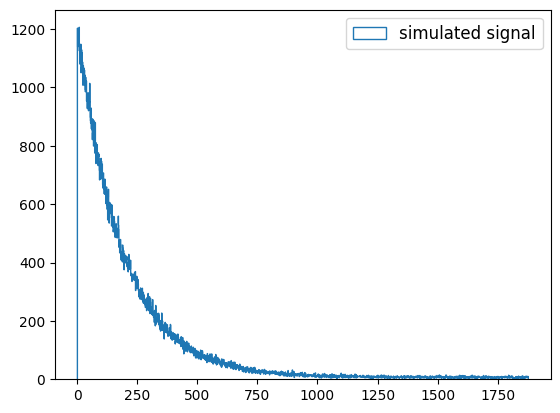

In [ ]:
#Example of simulation of 1 signal based on 3 weeks of data taking
a= simulation(baseline_perday*20.9, int(235749), create_pictures="yes")

In [ ]:
#Values from the signal To compare withe xperimental data and verify the simulation
signal= a[0]
print("After 5 tau_short:")
print('S(450) = ', signal[448:453])
print('S(650) = ', signal[648:653])
print('S(850) = ', signal[848:853])
print("After 5 tau_long:")
print('S(1050) = ', signal[1048:1053])
print('S(1250) = ', signal[1248:1253])
print('S(1450) = ', signal[1448:1453])
print('S(1650) = ', signal[1648:1653])

After 5 tau_short:
S(450) =  [117. 122. 126.  96. 113.]
S(650) =  [59. 34. 46. 39. 46.]
S(850) =  [23. 28. 22. 15. 15.]
After 5 tau_long:
S(1050) =  [ 9. 14. 11. 15. 14.]
S(1250) =  [ 5.  8. 11. 14.  7.]
S(1450) =  [ 7. 11.  8.  5. 10.]
S(1650) =  [11. 10.  8.  9.  5.]


# Definition of the fitting functions
### Fit full function fits the data to an exponential + Baseline with no previous estimation

### The other two functions first estimate the baseline by either an arithmetic mean or a pol0 fit and then use the statistics from this estimation as constraints for the full fitting

In [ ]:
def fit_full_function(base_input, signal, time_bins):
    fit_tau,fit_aplus,fit_bl,fit_errors,fit_pulls,fit_blerr,fit_blpull = [],[],[],[],[],[],[]
    for i in [0,5,6,7,8]:
      cut = i*tau_short
      x   = time_bins[cut:]
      y   = signal[cut:]

      fitting,cov = curve_fit(full_function, x, y, p0=(signal[0], 100, 1), method='trf')

      fit_tau.append(fitting[1])
      fit_aplus.append(fitting[0])
      fit_bl.append(fitting[2])
      fit_errors.append(np.sqrt(cov[1][1]))
      fit_blerr.append(np.sqrt(cov[2][2]))
      fit_pulls.append((fitting[1] - tau_long)/np.sqrt(cov[1][1]))
      fit_blpull.append((fitting[2] - base_input)/np.sqrt(cov[2][2]))

    return fit_tau, fit_aplus, fit_errors, fit_pulls, fit_bl, fit_blerr, fit_blpull

def fit_blmean_exp(base_input, signal, time_bins, bl_cut=5):
    base_est = np.mean(signal[bl_cut*tau_long:])
    base_std = np.std(signal[bl_cut*tau_long:])/np.sqrt(len(signal[bl_cut*tau_long:]))

    fit_tau,fit_aplus,fit_bl,fit_errors,fit_pulls,fit_blerr,fit_blpull = [],[],[],[],[],[],[]
    for i in [0,5,6,7,8]:
      cut = i*tau_short
      x   = time_bins[cut:]
      y   = signal[cut:]

      bound =([-np.inf,-np.inf,base_est-5*base_std], [np.inf,np.inf,base_est + 5*base_std])
      fitting,cov = curve_fit(full_function, x, y, p0=(signal[0], 100, base_est), bounds=bound)

      fit_tau.append(fitting[1])
      fit_aplus.append(fitting[0])
      fit_bl.append(fitting[2])
      fit_errors.append(np.sqrt(cov[1][1]))
      fit_blerr.append(np.sqrt(cov[2][2]))
      fit_pulls.append((fitting[1] - tau_long)/np.sqrt(cov[1][1]))
      fit_blpull.append((fitting[2] - base_input)/np.sqrt(cov[2][2]))

    return fit_tau, fit_aplus, fit_errors, fit_pulls, fit_bl, fit_blerr, fit_blpull

def fit_blp0_exp(base_input, signal, time_bins, bl_cut=5):
    count_cut    = bl_cut*tau_long
    fitted, covd = curve_fit(p0_fit, time_bins[count_cut:], signal[count_cut:], method='trf')
    base_est     = fitted[0]
    base_std     = np.sqrt(covd[0][0])

    fit_tau,fit_aplus,fit_bl,fit_errors,fit_pulls,fit_blerr,fit_blpull = [],[],[],[],[],[],[]
    for i in [0,5,6,7,8]:
      cut = i*tau_short
      x   = time_bins[cut:]
      y   = signal[cut:]

      bound =([-np.inf,-np.inf,base_est-5*base_std], [np.inf,np.inf,base_est + 5*base_std])
      fitting,cov = curve_fit(full_function, x, y, p0=(signal[0], 100, base_est), bounds=bound)

      fit_tau.append(fitting[1])
      fit_aplus.append(fitting[0])
      fit_bl.append(fitting[2])
      fit_errors.append(np.sqrt(cov[1][1]))
      fit_blerr.append(np.sqrt(cov[2][2]))
      fit_pulls.append((fitting[1] - tau_long)/np.sqrt(cov[1][1]))
      fit_blpull.append((fitting[2] - base_input)/np.sqrt(cov[2][2]))

    return fit_tau, fit_aplus, fit_errors, fit_pulls, fit_bl, fit_blerr, fit_blpull

# Function that pulls simulation results

### This funcation outputs 9 Dataframes of 35 columns. Every Dataframe corresponds to a different method of estimation of the baseline before fitting the function. The columns instead represent the data obtained for the fitting  parameters, based on different ranges of fitting.

In [ ]:
def pull_sim_statistics(timeframe, n_sims):
    baseline = baseline_perday*timeframe
    numberofentries = int(week*timeframe/7)

    col_names  = ["tau_full", "tau_5s", "tau_6s","tau_7s", "tau_8s",
                  "err_full","err_5s","err_6s","err_7s","err_8s",
                  "Tpull_full","Tpull_5s","Tpull_6s","Tpull_7s","Tpull_8s",
                  "base_full","base_5s","base_6s","base_7s","base_8s",
                  "errb_full","errb_5s","errb_6s","errb_7s","errb_8s",
                  "Bpull_full","Bpull_5s","Bpull_6s","Bpull_7s","Bpull_8s",
                  "amp_full","amp_5s","amp_6s","amp_7s","amp_8s"]

    rows = []
    rows_mean_5, rows_pol0_5 = [],[]
    rows_mean_6, rows_pol0_6 = [],[]
    rows_mean_7, rows_pol0_7 = [],[]
    rows_mean_8, rows_pol0_8 = [],[]

    for i in range(n_sims):
        print("Running sim #", i+1)
        counts_signal, bin_centers = simulation(baseline, numberofentries)
        print('fitting full function:')
        results_tuple = fit_full_function(baseline, counts_signal, bin_centers)
        taus, aplus, errors, spread, baselines, err_baselines, blpull = results_tuple
        rows.append(taus + errors + spread + baselines + err_baselines + blpull + aplus)

        print('fitting with initial baseline estimation after 5 tau long')
        results_tuple = fit_blmean_exp(baseline, counts_signal,bin_centers, 5)
        btaus, baplus, berrors, bspread, bbaselines, berr_baselines, bblpull = results_tuple
        rows_mean_5.append(btaus + berrors + bspread + bbaselines + berr_baselines + bblpull + baplus)
        results_tuple = fit_blp0_exp(baseline, counts_signal,bin_centers, 5)
        btaus, baplus, berrors, bspread, bbaselines, berr_baselines, bblpull = results_tuple
        rows_pol0_5.append(btaus + berrors + bspread + bbaselines + berr_baselines + bblpull + baplus)

        print('fitting with initial baseline estimation after 6 tau long')
        results_tuple = fit_blmean_exp(baseline, counts_signal,bin_centers, 6)
        btaus, baplus, berrors, bspread, bbaselines, berr_baselines, bblpull = results_tuple
        rows_mean_6.append(btaus + berrors + bspread + bbaselines + berr_baselines + bblpull + baplus)
        results_tuple = fit_blp0_exp(baseline, counts_signal,bin_centers, 6)
        btaus, baplus, berrors, bspread, bbaselines, berr_baselines, bblpull = results_tuple
        rows_pol0_6.append(btaus + berrors + bspread + bbaselines + berr_baselines + bblpull + baplus)

        print('fitting with initial baseline estimation after 7 tau long')
        results_tuple = fit_blmean_exp(baseline, counts_signal,bin_centers, 7)
        btaus, baplus, berrors, bspread, bbaselines, berr_baselines, bblpull = results_tuple
        rows_mean_7.append(btaus + berrors + bspread + bbaselines + berr_baselines + bblpull + baplus)
        results_tuple = fit_blp0_exp(baseline, counts_signal,bin_centers, 7)
        btaus, baplus, berrors, bspread, bbaselines, berr_baselines, bblpull = results_tuple
        rows_pol0_7.append(btaus + berrors + bspread + bbaselines + berr_baselines + bblpull + baplus)

        print('fitting with initial baseline estimation after 8 tau long')
        results_tuple = fit_blmean_exp(baseline, counts_signal,bin_centers, 8)
        btaus, baplus, berrors, bspread, bbaselines, berr_baselines, bblpull = results_tuple
        rows_mean_8.append(btaus + berrors + bspread + bbaselines + berr_baselines + bblpull + baplus)
        results_tuple = fit_blp0_exp(baseline, counts_signal,bin_centers, 8)
        btaus, baplus, berrors, bspread, bbaselines, berr_baselines, bblpull = results_tuple
        rows_pol0_8.append(btaus + berrors + bspread + bbaselines + berr_baselines + bblpull + baplus)

        clear_output(wait ="True")

    df_full   = pd.DataFrame(rows, columns=col_names)

    df_mean_5 = pd.DataFrame(rows_mean_5, columns=col_names)
    df_mean_6 = pd.DataFrame(rows_mean_6, columns=col_names)
    df_mean_7 = pd.DataFrame(rows_mean_7, columns=col_names)
    df_mean_8 = pd.DataFrame(rows_mean_8, columns=col_names)

    df_pol0_5 = pd.DataFrame(rows_pol0_5, columns=col_names)
    df_pol0_6 = pd.DataFrame(rows_pol0_6, columns=col_names)
    df_pol0_7 = pd.DataFrame(rows_pol0_7, columns=col_names)
    df_pol0_8 = pd.DataFrame(rows_pol0_8, columns=col_names)

    return df_full, df_mean_5, df_mean_6, df_mean_7, df_mean_8, df_pol0_5, df_pol0_6, df_pol0_7, df_pol0_8

## Now running the pull_sim_statistics that run the given number of simulations

In [ ]:
stats_week  = pull_sim_statistics(7,1000)
strings = ["full",
           "5taul_mean","6taul_mean","7taul_mean","8taul_mean",
           "5taul_pol0","6taul_pol0","7taul_pol0","8taul_pol0"]
for df,name in zip(stats_week, strings):
  df.to_csv("Week_%s.csv"%name)

Running sim # 1000
fitting full function:
fitting with initial baseline estimation after 5 tau long
fitting with initial baseline estimation after 6 tau long
fitting with initial baseline estimation after 7 tau long
fitting with initial baseline estimation after 8 tau long


In [ ]:
stats_3week  = pull_sim_statistics(21,1000)
for df,name in zip(stats_3week, strings):
  df.to_csv("3Week_%s.csv"%name)

Running sim # 1000
fitting full function:
fitting with initial baseline estimation after 5 tau long
fitting with initial baseline estimation after 6 tau long
fitting with initial baseline estimation after 7 tau long
fitting with initial baseline estimation after 8 tau long


In [ ]:
stats_5week  = pull_sim_statistics(35,1000)
for df,name in zip(stats_5week, strings):
  df.to_csv("5Week_%s.csv"%name)

NameError: ignored

## 1000 Simulation Histogram
 Functions that create Plots and final data results for each of the parameters obatined during fitting of 1000 simulated signals

In [ ]:
# Function that creates a single graph with many histograms for different fits of
# one parameter and returns the final results
def single_hist(dataf, array, naming, create_figures ="yes"):
  results = []
  stddev  = []
  for cut in array:
    counts, bines,_ = plt.hist(dataf[cut],bins=50,density ="True",
                            histtype="step")
    bin_mids = (bines[:-1] + bines[1:])/2.
    parameters, _ = curve_fit(pana_gauss, bin_mids, counts, p0=(bines[25], bines[25]**0.5))
    results.append(parameters[0])
    stddev.append(parameters[1])

  plt.title("Simulated %s for a %s period" %naming)
  plt.legend(["%s : %.3f +- %.2f" %(i,j,k) for i,j,k in zip(array, results,stddev)])

  fig = plt.gcf()
  if create_figures=="yes":
    plt.show()
  fig.savefig("%s_%s.png" %naming)
  plt.close()

  return results


#this function runs single)hist for all of the parameters in a results dataframe
def plotter(dataf, naming="gen", create_figures="yes"):
  tau_columnns = dataf.columns.values.tolist()

  timel_vals = single_hist(dataf, tau_columnns[0:5], ("TauLong", naming), create_figures)
  err_vals   = single_hist(dataf, tau_columnns[5:10], ("TauLong_Errors", naming), create_figures)
  pull_vals  = single_hist(dataf, tau_columnns[10:15], ("TauLong_Pulls", naming), create_figures)
  base_vals  = single_hist(dataf, tau_columnns[15:20], ("Baseline", naming), create_figures)
  berr_vals  = single_hist(dataf, tau_columnns[20:25], ("Baseline_errors", naming), create_figures)
  bpull_vals = single_hist(dataf, tau_columnns[25:30], ("Baseline_Pulls", naming), create_figures)

  return timel_vals, err_vals, pull_vals, base_vals, berr_vals, bpull_vals

In [ ]:
#run for one dataframe
dataframetoplot=pd.read_csv('5Week_7taul_pol0.csv', header=0,index_col=0)
time,error,pull,basel,baserr,basepull = plotter(dataframetoplot, "1Week_5l_pol0","yes")
printer =["Tau long estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(time, error) ]
print("Values for simulated week of data taking at different cuts")
for i in printer:
  print(i)

print("Baseline for simulated week of data taking at different cuts")
printer =["Baseline estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(basel, baserr) ]
for i in printer:
  print(i)

dataframetoplot=pd.read_csv('5Week_7taul_mean.csv', header=0,index_col=0)
time,error,pull,basel,baserr,basepull = plotter(dataframetoplot, "1Week_5l_pol0","yes")
printer =["Tau long estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(time, error) ]
print("Values for simulated week of data taking at different cuts")
for i in printer:
  print(i)

print("Baseline for simulated week of data taking at different cuts")
printer =["Baseline estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(basel, baserr) ]
for i in printer:
  print(i)

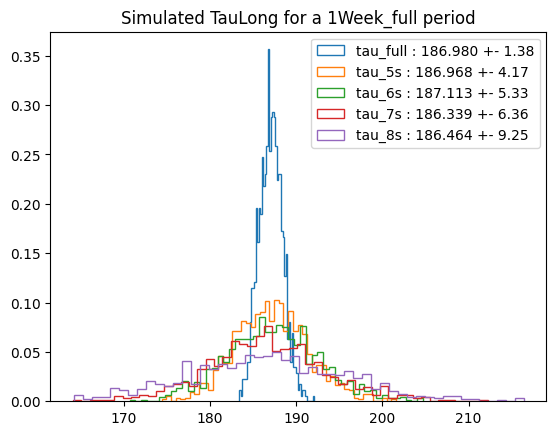

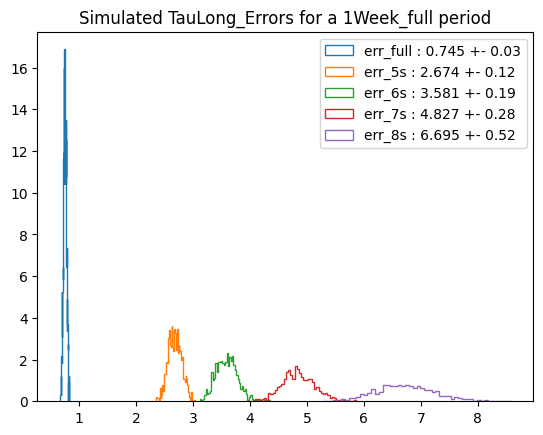

<ipython-input-12-ccf7047b5220>:10: RuntimeWarning: invalid value encountered in double_scalars
  parameters, _ = curve_fit(pana_gauss, bin_mids, counts, p0=(bines[25], bines[25]**0.5))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


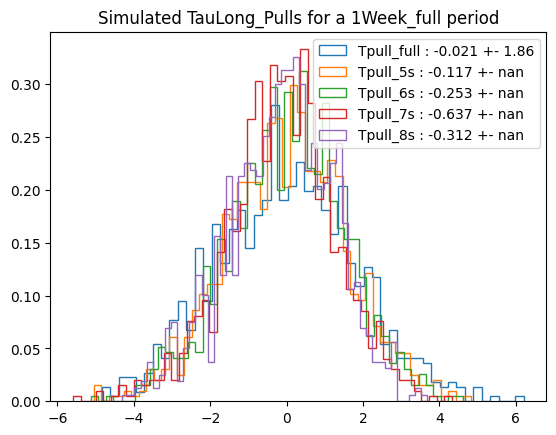

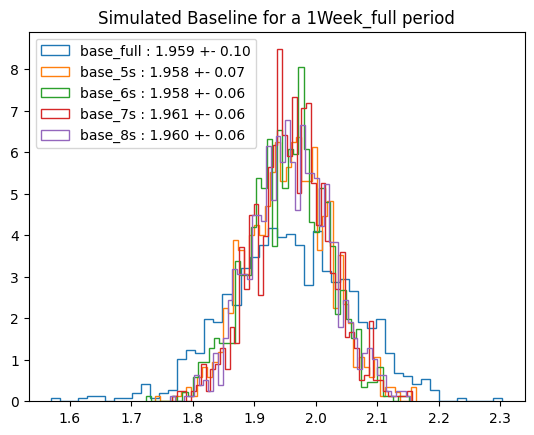

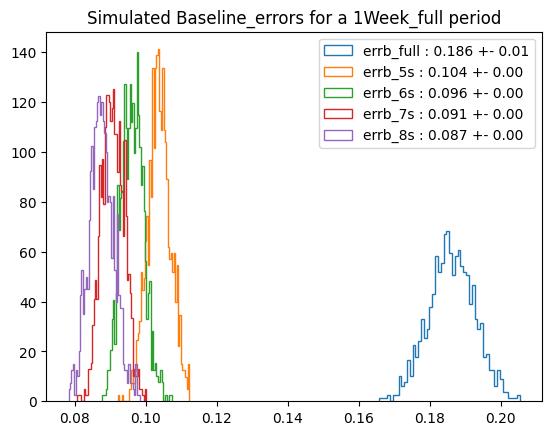

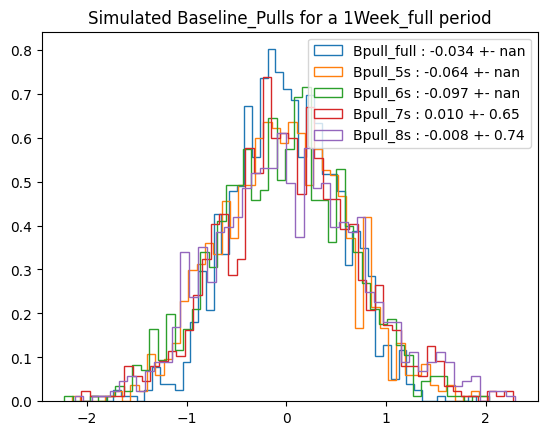

Values for simulated week of data taking at different cuts
Tau long estimation: 186.97996 +/- 0.74517
Tau long estimation: 186.96833 +/- 2.67374
Tau long estimation: 187.11324 +/- 3.58073
Tau long estimation: 186.33897 +/- 4.82669
Tau long estimation: 186.46432 +/- 6.69528
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.95905 +/- 0.18610
Baseline estimation: 1.95755 +/- 0.10367
Baseline estimation: 1.95782 +/- 0.09613
Baseline estimation: 1.96140 +/- 0.09059
Baseline estimation: 1.95973 +/- 0.08735


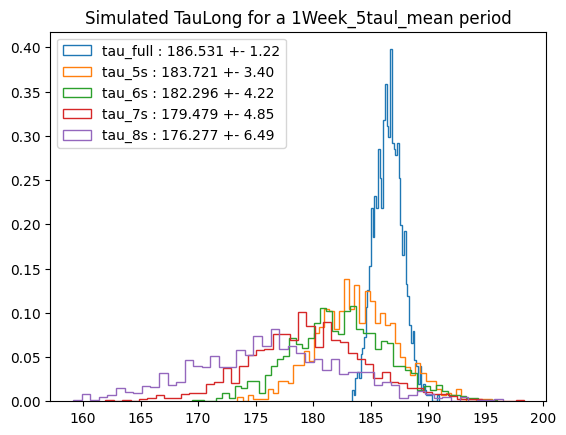

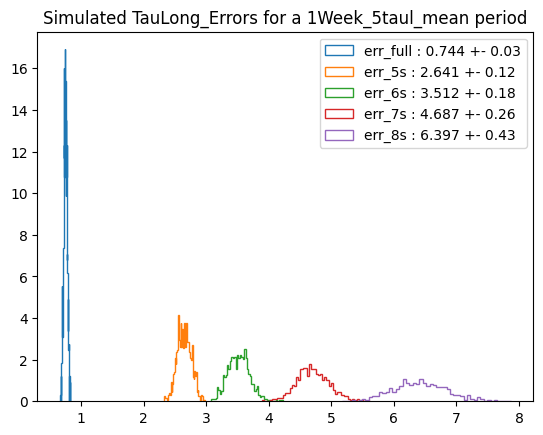

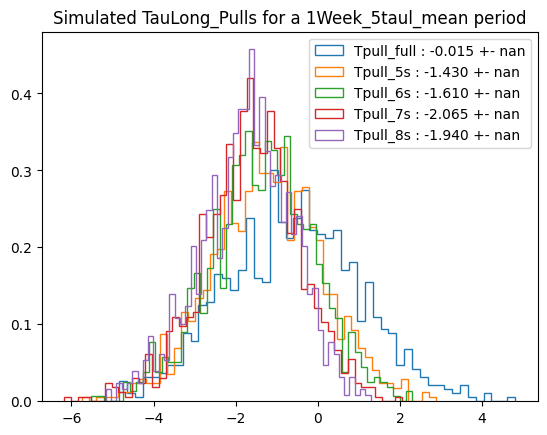

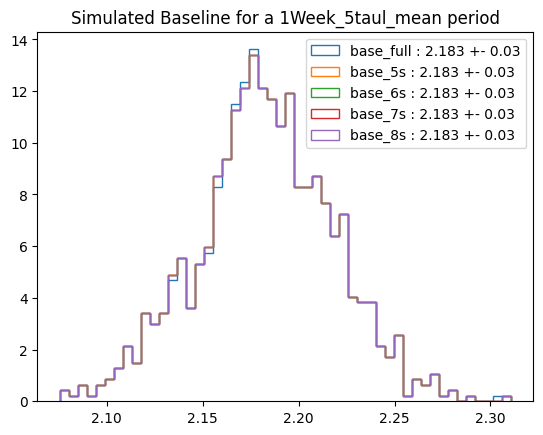

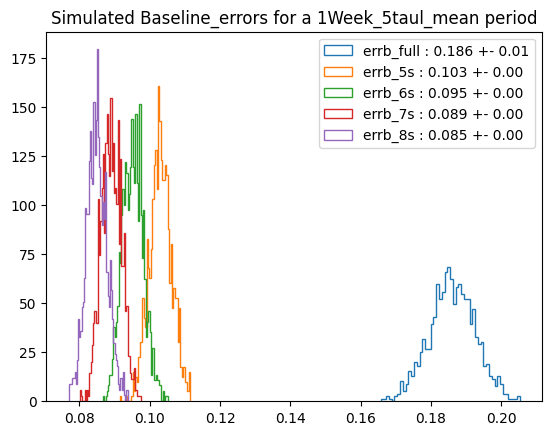

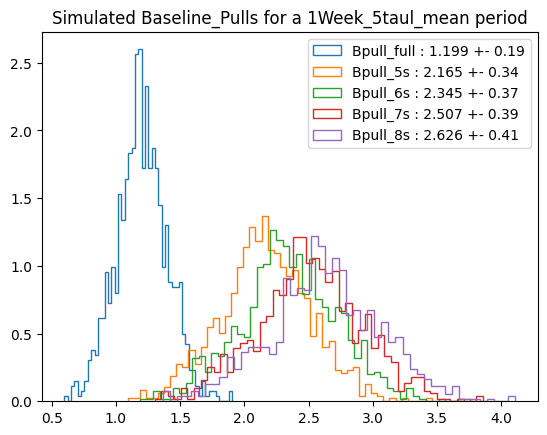

Values for simulated week of data taking at different cuts
Tau long estimation: 186.53090 +/- 0.74429
Tau long estimation: 183.72061 +/- 2.64117
Tau long estimation: 182.29618 +/- 3.51190
Tau long estimation: 179.47947 +/- 4.68731
Tau long estimation: 176.27696 +/- 6.39728
Baseline for simulated week of data taking at different cuts
Baseline estimation: 2.18340 +/- 0.18604
Baseline estimation: 2.18327 +/- 0.10298
Baseline estimation: 2.18327 +/- 0.09507
Baseline estimation: 2.18327 +/- 0.08897
Baseline estimation: 2.18327 +/- 0.08476


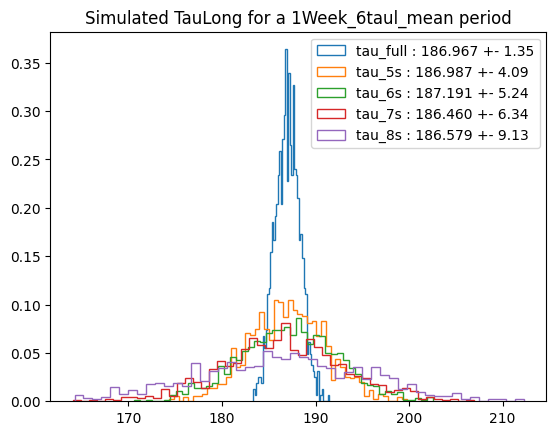

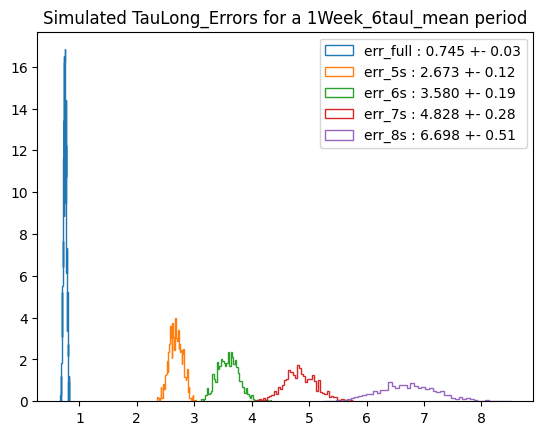

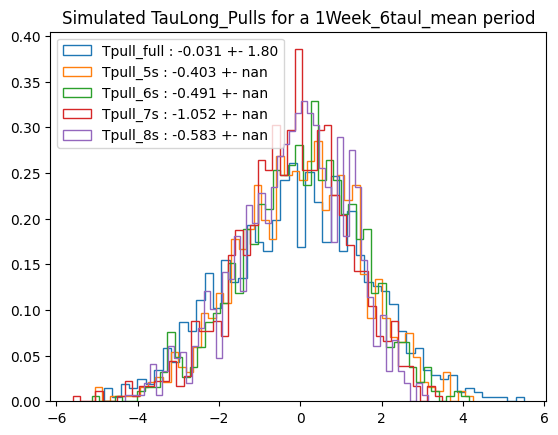

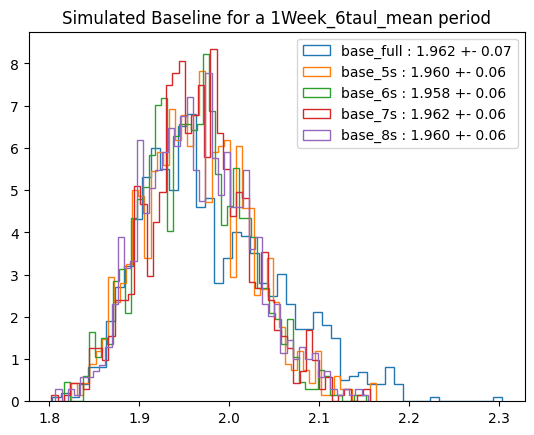

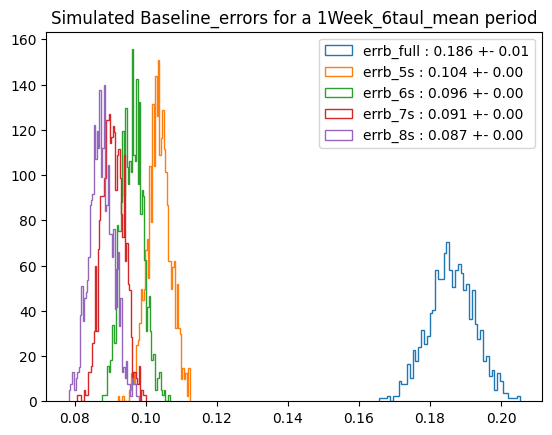

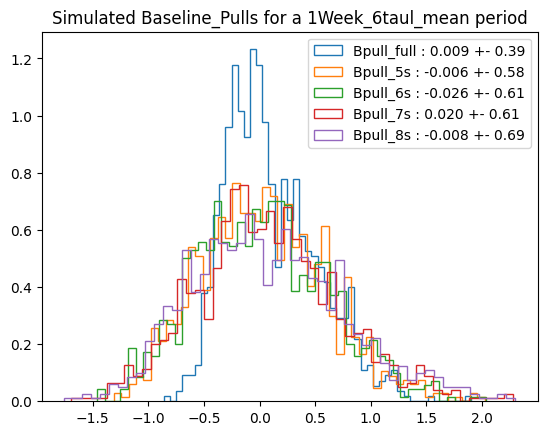

Values for simulated week of data taking at different cuts
Tau long estimation: 186.96705 +/- 0.74508
Tau long estimation: 186.98731 +/- 2.67319
Tau long estimation: 187.19090 +/- 3.58029
Tau long estimation: 186.45970 +/- 4.82773
Tau long estimation: 186.57889 +/- 6.69827
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.96187 +/- 0.18610
Baseline estimation: 1.95962 +/- 0.10364
Baseline estimation: 1.95792 +/- 0.09611
Baseline estimation: 1.96219 +/- 0.09056
Baseline estimation: 1.95977 +/- 0.08734


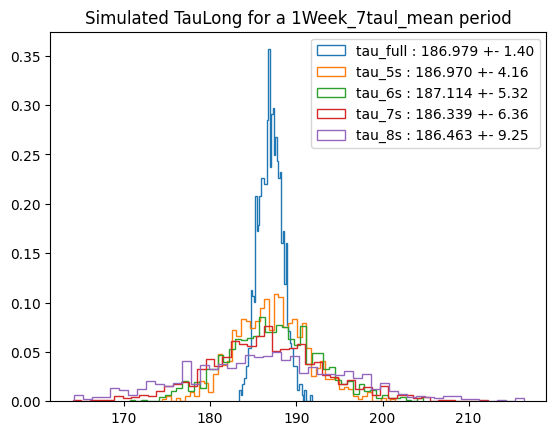

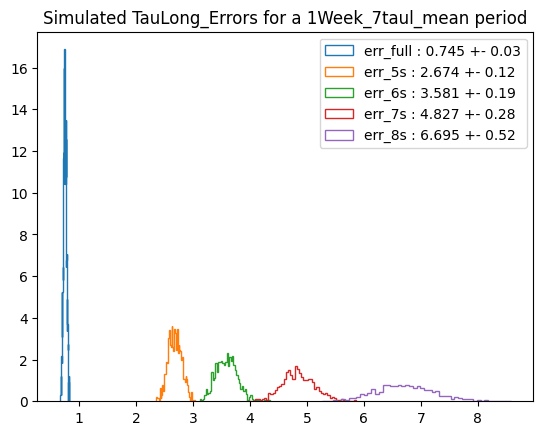

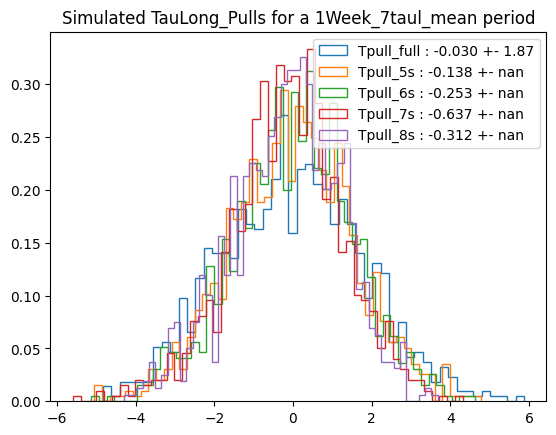

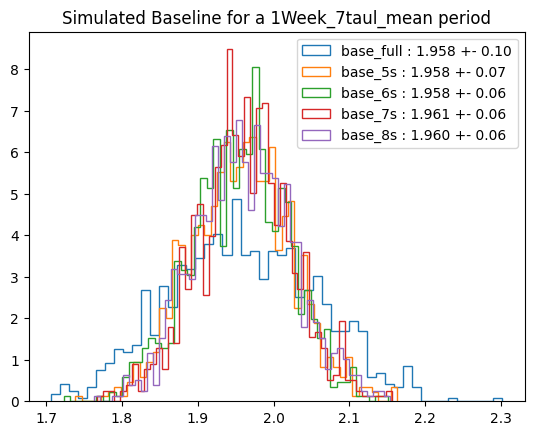

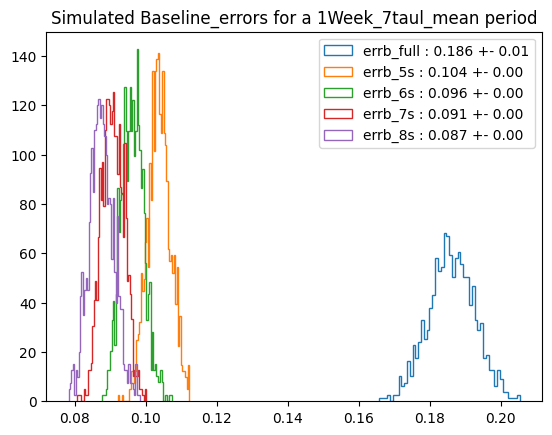

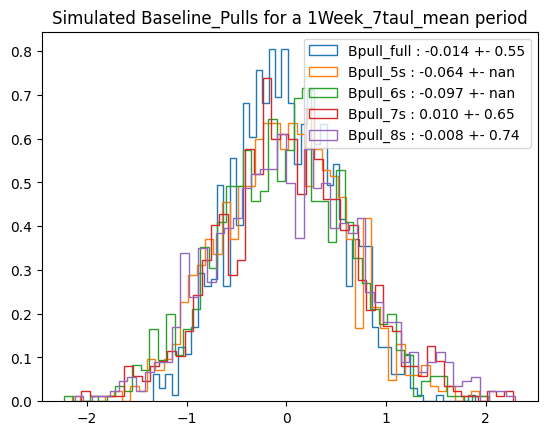

Values for simulated week of data taking at different cuts
Tau long estimation: 186.97871 +/- 0.74517
Tau long estimation: 186.97007 +/- 2.67374
Tau long estimation: 187.11381 +/- 3.58073
Tau long estimation: 186.33940 +/- 4.82669
Tau long estimation: 186.46324 +/- 6.69529
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.95795 +/- 0.18609
Baseline estimation: 1.95753 +/- 0.10367
Baseline estimation: 1.95781 +/- 0.09613
Baseline estimation: 1.96140 +/- 0.09059
Baseline estimation: 1.95973 +/- 0.08735


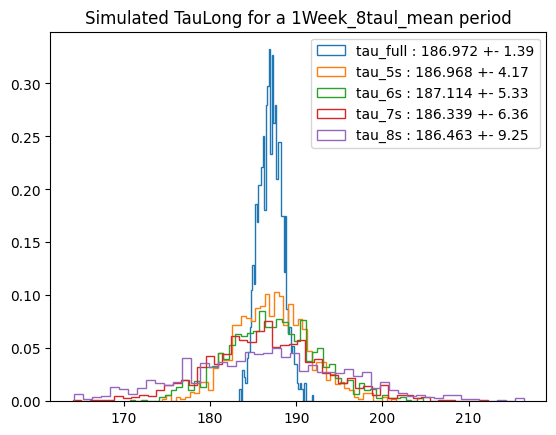

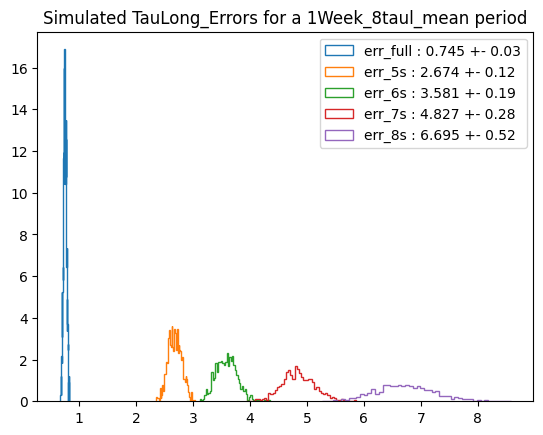

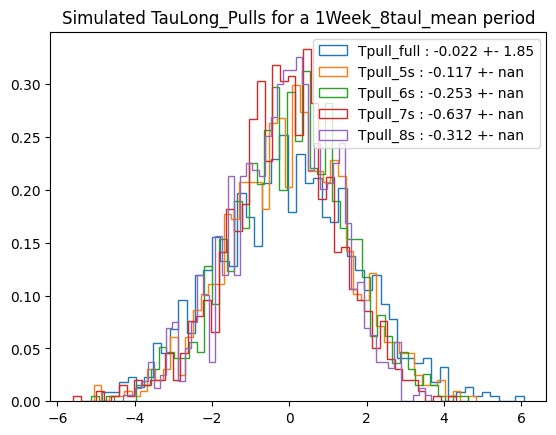

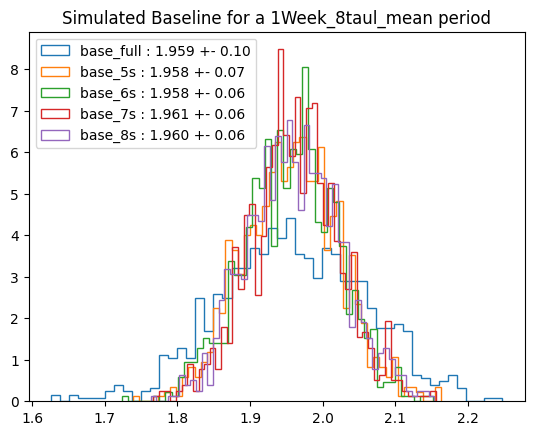

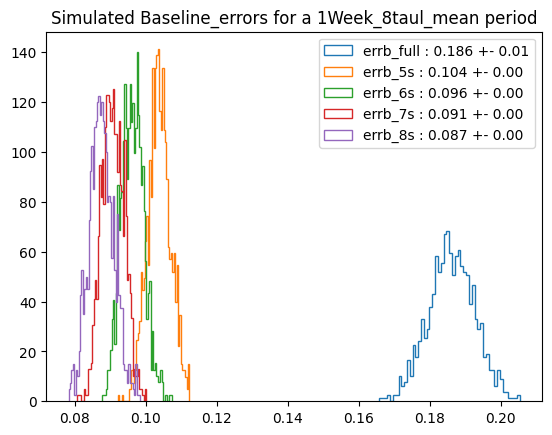

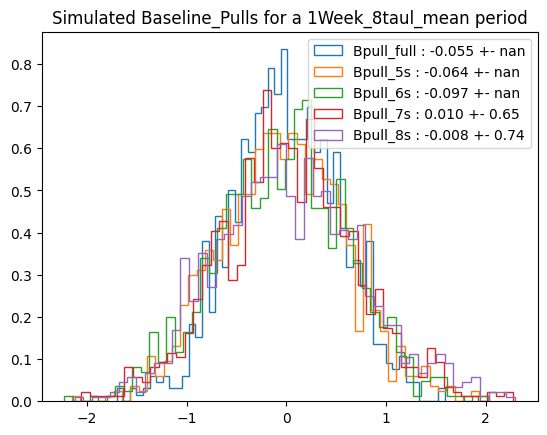

Values for simulated week of data taking at different cuts
Tau long estimation: 186.97192 +/- 0.74517
Tau long estimation: 186.96838 +/- 2.67374
Tau long estimation: 187.11423 +/- 3.58073
Tau long estimation: 186.33902 +/- 4.82668
Tau long estimation: 186.46320 +/- 6.69528
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.95868 +/- 0.18610
Baseline estimation: 1.95755 +/- 0.10367
Baseline estimation: 1.95783 +/- 0.09613
Baseline estimation: 1.96140 +/- 0.09059
Baseline estimation: 1.95973 +/- 0.08735


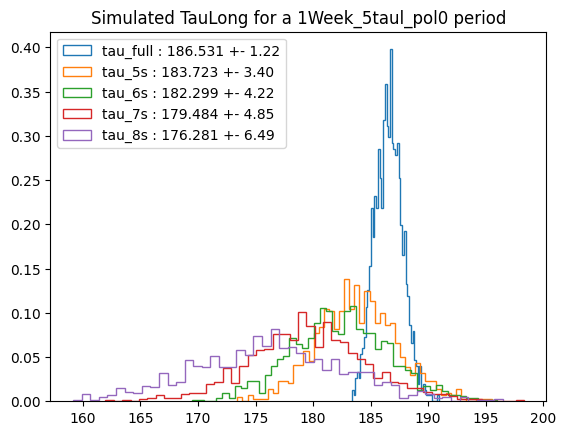

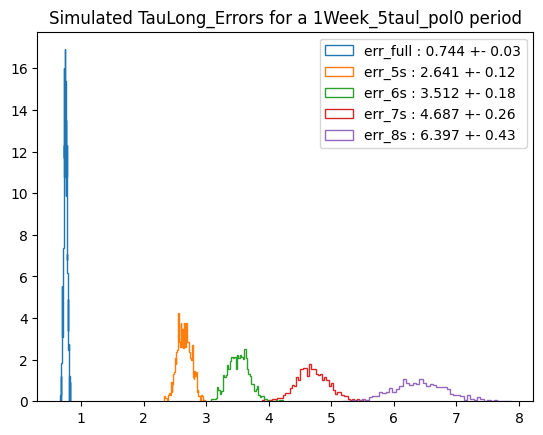

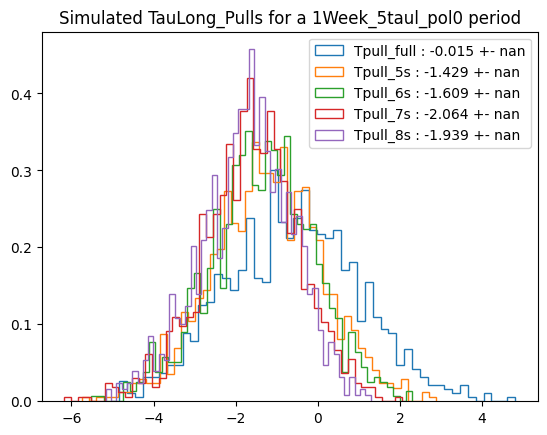

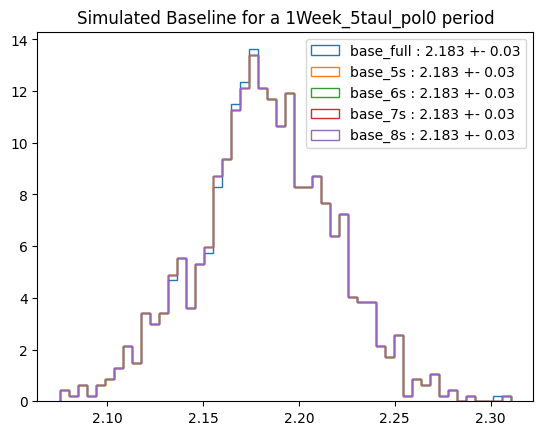

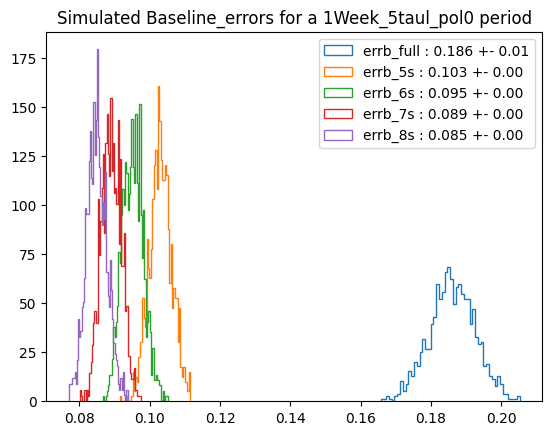

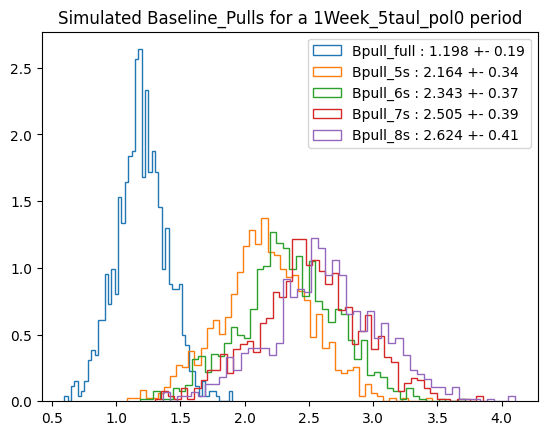

Values for simulated week of data taking at different cuts
Tau long estimation: 186.53102 +/- 0.74429
Tau long estimation: 183.72264 +/- 2.64118
Tau long estimation: 182.29917 +/- 3.51194
Tau long estimation: 179.48385 +/- 4.68739
Tau long estimation: 176.28149 +/- 6.39746
Baseline for simulated week of data taking at different cuts
Baseline estimation: 2.18326 +/- 0.18604
Baseline estimation: 2.18313 +/- 0.10298
Baseline estimation: 2.18313 +/- 0.09507
Baseline estimation: 2.18313 +/- 0.08897
Baseline estimation: 2.18313 +/- 0.08477


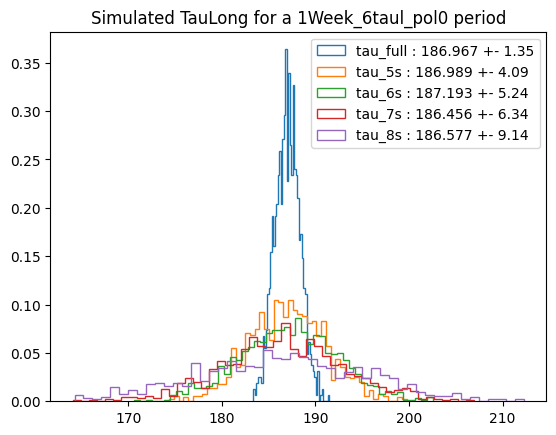

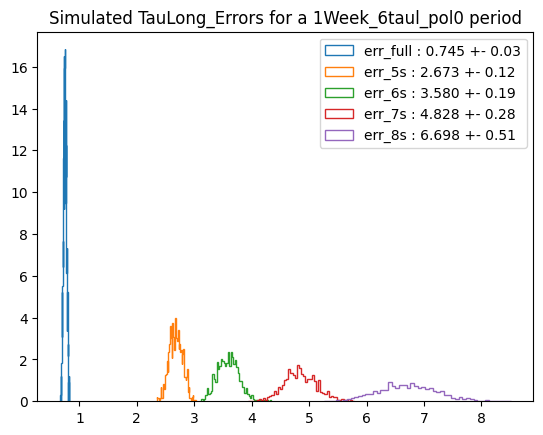

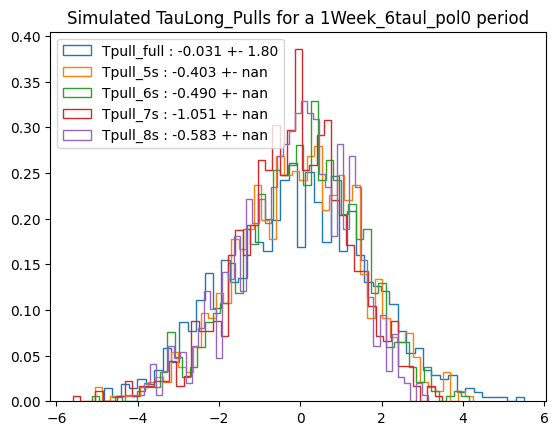

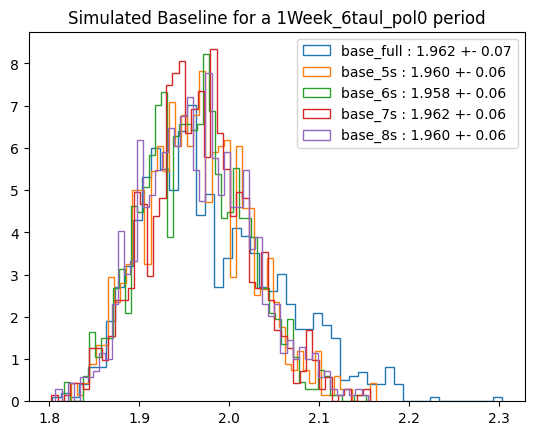

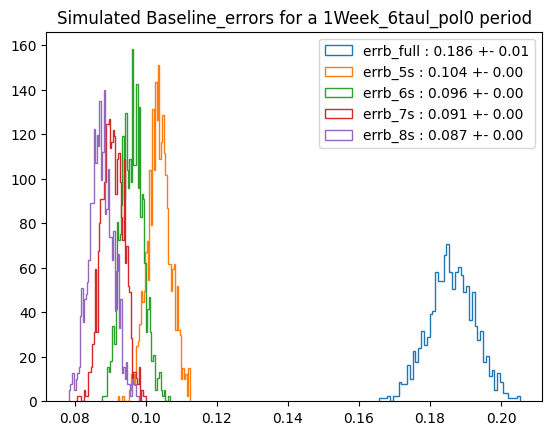

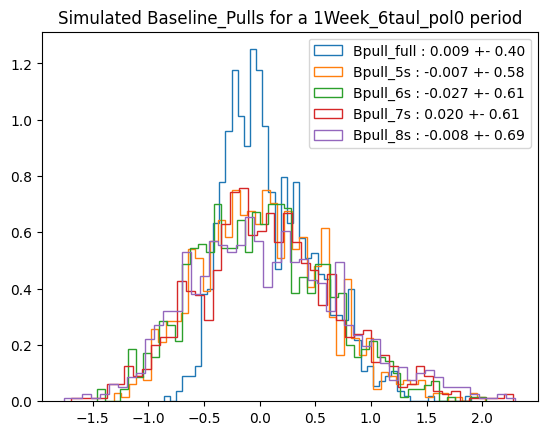

Values for simulated week of data taking at different cuts
Tau long estimation: 186.96726 +/- 0.74508
Tau long estimation: 186.98872 +/- 2.67321
Tau long estimation: 187.19303 +/- 3.58032
Tau long estimation: 186.45638 +/- 4.82775
Tau long estimation: 186.57697 +/- 6.69825
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.96184 +/- 0.18610
Baseline estimation: 1.95960 +/- 0.10364
Baseline estimation: 1.95791 +/- 0.09611
Baseline estimation: 1.96217 +/- 0.09056
Baseline estimation: 1.95979 +/- 0.08734


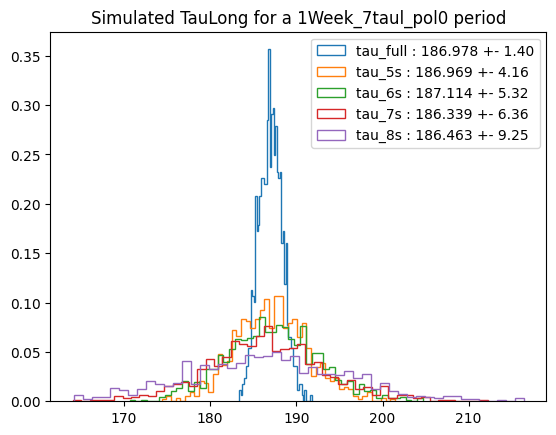

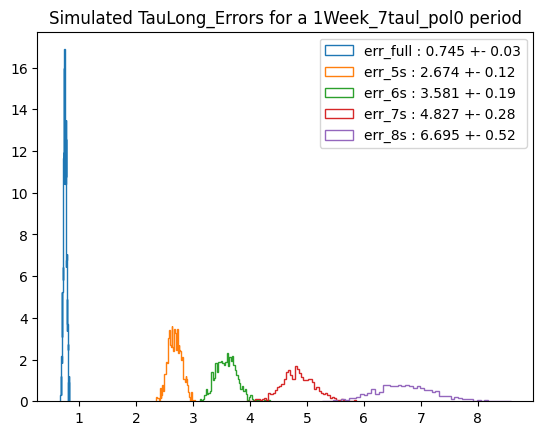

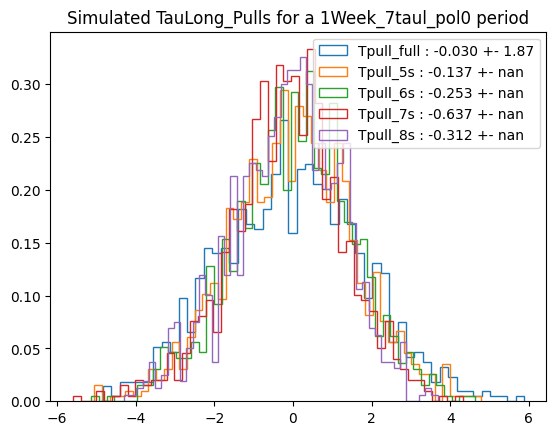

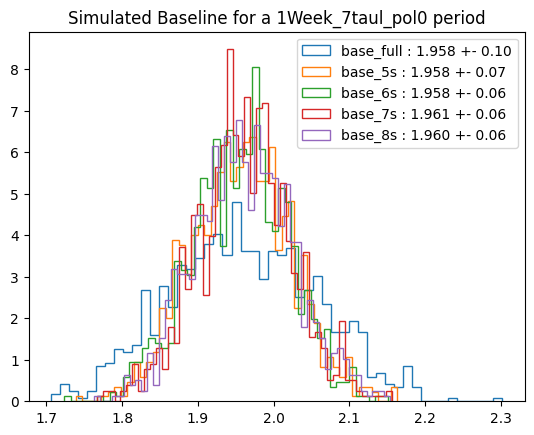

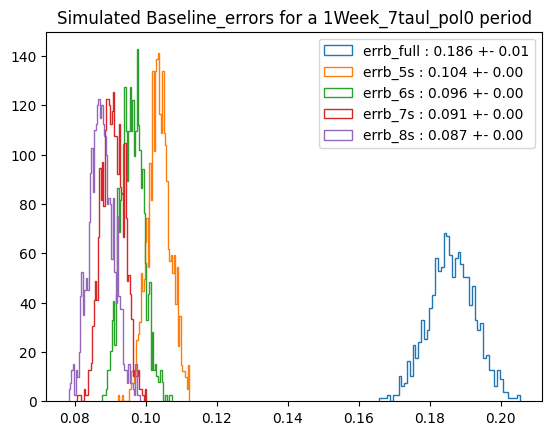

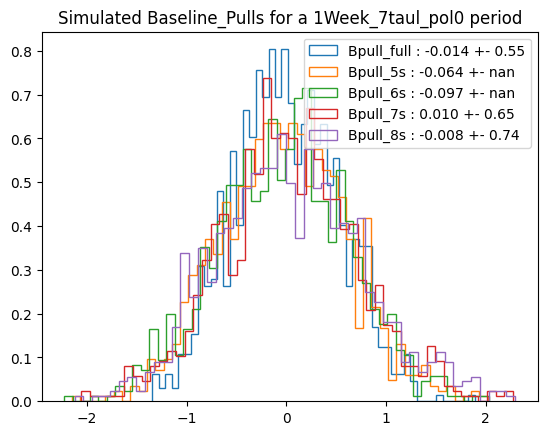

Values for simulated week of data taking at different cuts
Tau long estimation: 186.97817 +/- 0.74517
Tau long estimation: 186.96919 +/- 2.67374
Tau long estimation: 187.11381 +/- 3.58073
Tau long estimation: 186.33940 +/- 4.82669
Tau long estimation: 186.46324 +/- 6.69529
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.95793 +/- 0.18609
Baseline estimation: 1.95753 +/- 0.10367
Baseline estimation: 1.95781 +/- 0.09613
Baseline estimation: 1.96140 +/- 0.09059
Baseline estimation: 1.95973 +/- 0.08735


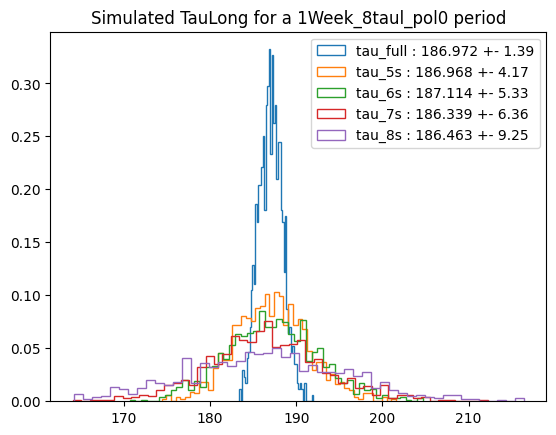

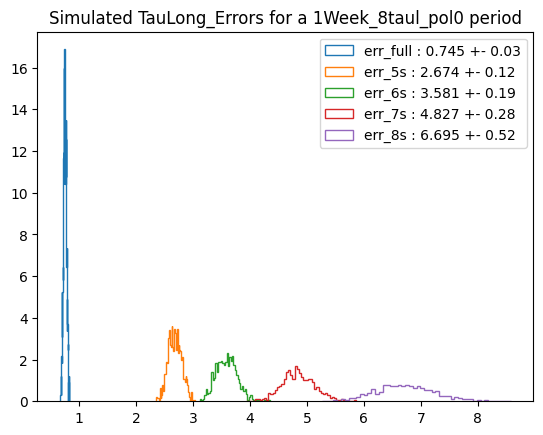

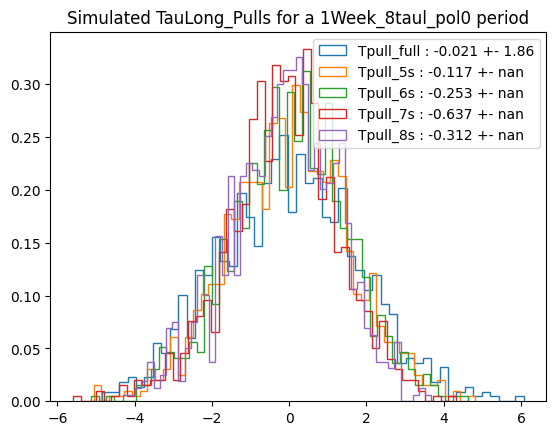

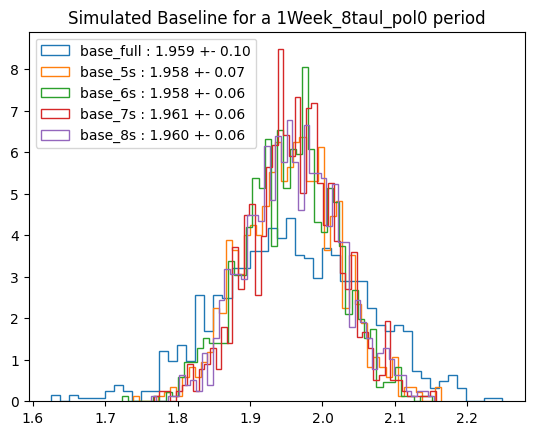

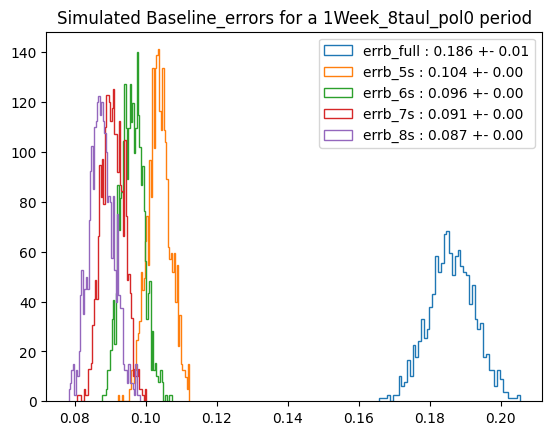

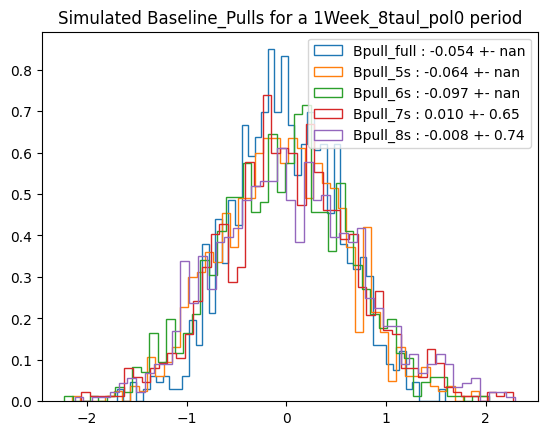

Values for simulated week of data taking at different cuts
Tau long estimation: 186.97233 +/- 0.74517
Tau long estimation: 186.96838 +/- 2.67374
Tau long estimation: 187.11423 +/- 3.58073
Tau long estimation: 186.33901 +/- 4.82668
Tau long estimation: 186.46319 +/- 6.69528
Baseline for simulated week of data taking at different cuts
Baseline estimation: 1.95873 +/- 0.18610
Baseline estimation: 1.95755 +/- 0.10367
Baseline estimation: 1.95783 +/- 0.09613
Baseline estimation: 1.96140 +/- 0.09059
Baseline estimation: 1.95973 +/- 0.08735


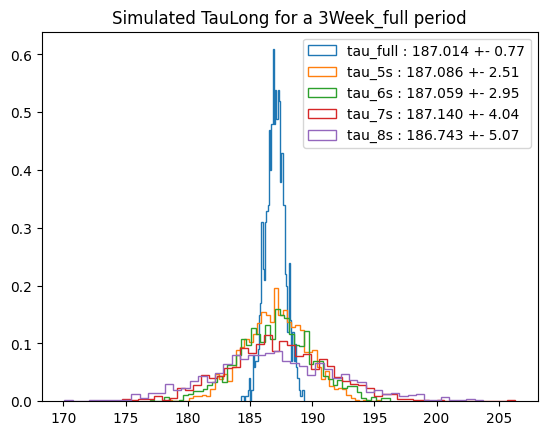

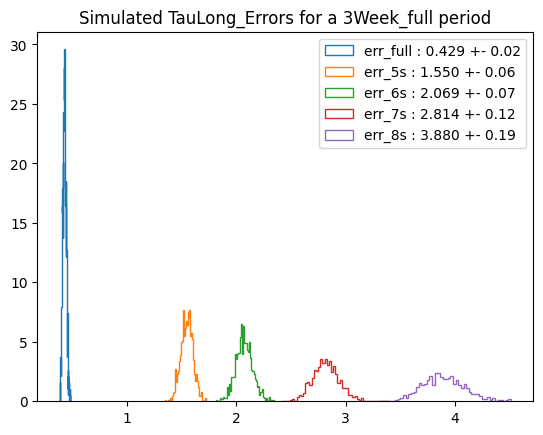

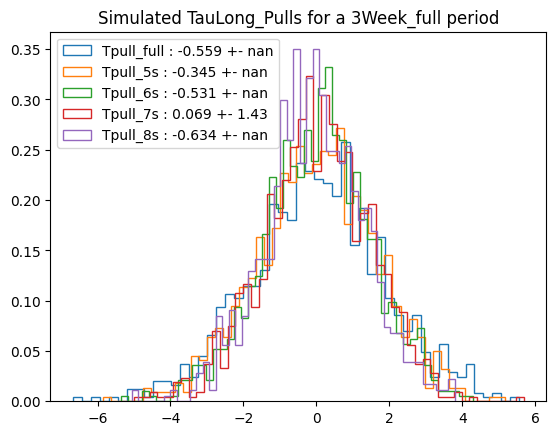

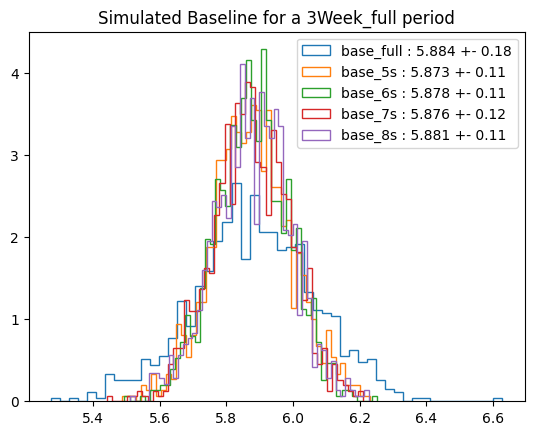

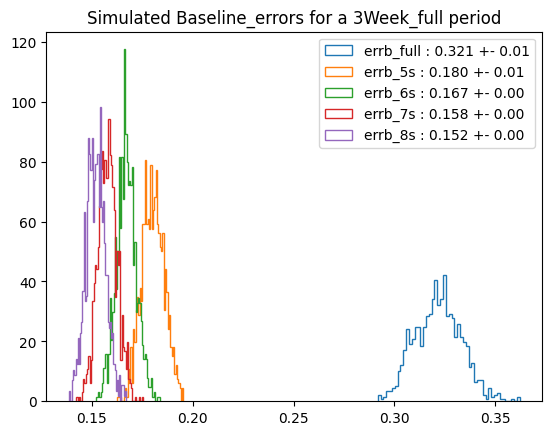

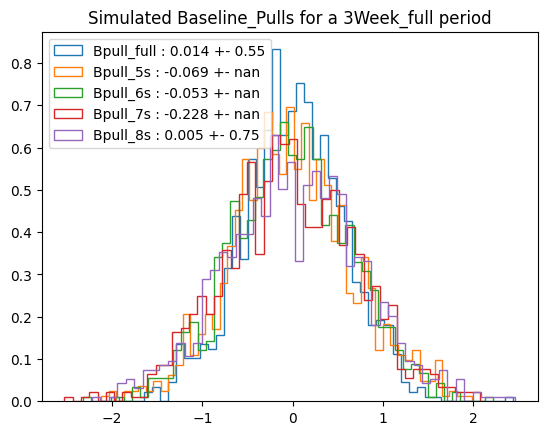

Values for simulated week of data taking at different cuts
Tau long estimation: 187.01396 +/- 0.42916
Tau long estimation: 187.08644 +/- 1.55003
Tau long estimation: 187.05900 +/- 2.06883
Tau long estimation: 187.14042 +/- 2.81437
Tau long estimation: 186.74251 +/- 3.87987
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.88442 +/- 0.32140
Baseline estimation: 5.87304 +/- 0.18011
Baseline estimation: 5.87768 +/- 0.16692
Baseline estimation: 5.87579 +/- 0.15766
Baseline estimation: 5.88138 +/- 0.15185


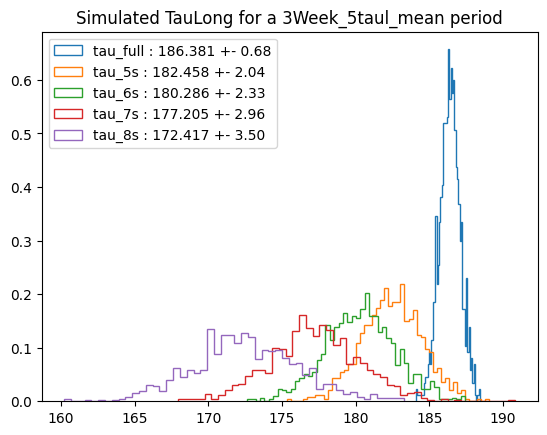

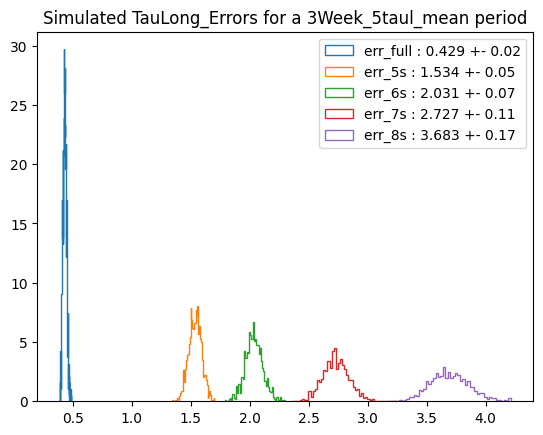

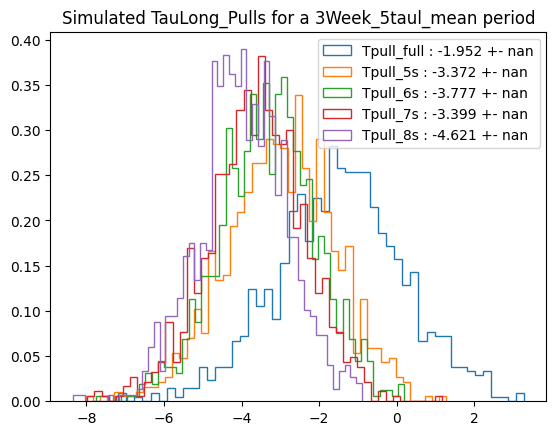

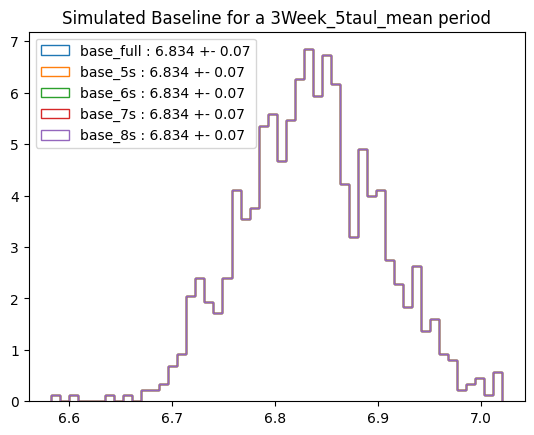

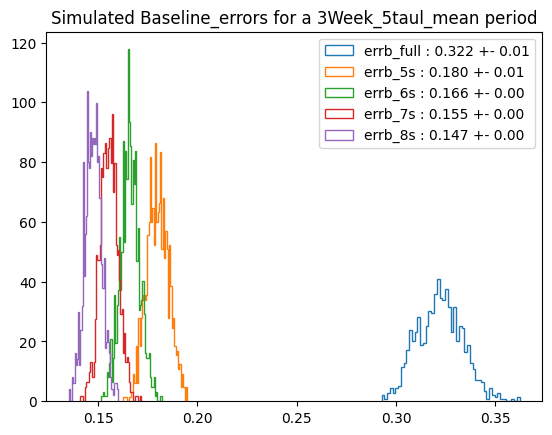

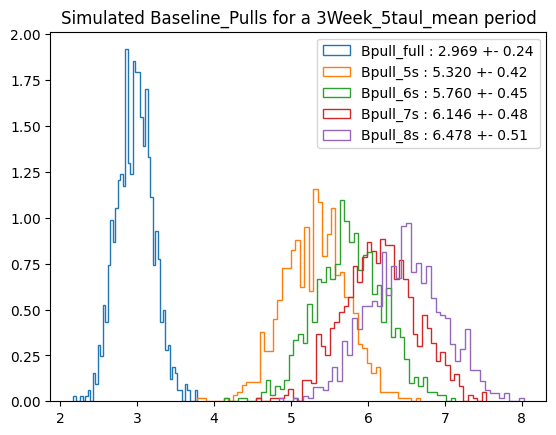

Values for simulated week of data taking at different cuts
Tau long estimation: 186.38071 +/- 0.42918
Tau long estimation: 182.45828 +/- 1.53448
Tau long estimation: 180.28579 +/- 2.03131
Tau long estimation: 177.20467 +/- 2.72708
Tau long estimation: 172.41659 +/- 3.68280
Baseline for simulated week of data taking at different cuts
Baseline estimation: 6.83362 +/- 0.32178
Baseline estimation: 6.83362 +/- 0.17976
Baseline estimation: 6.83362 +/- 0.16583
Baseline estimation: 6.83362 +/- 0.15527
Baseline estimation: 6.83362 +/- 0.14743


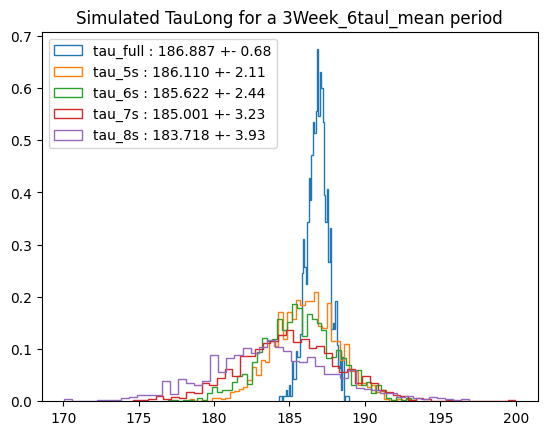

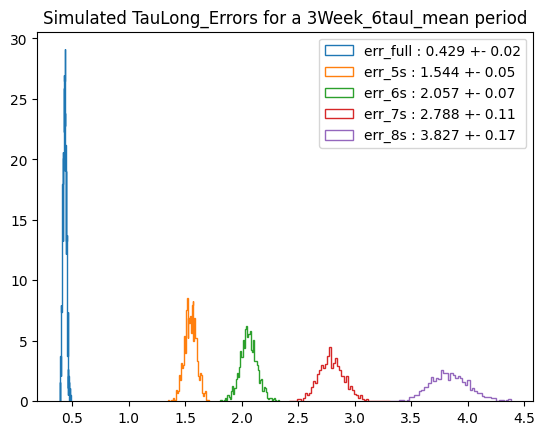

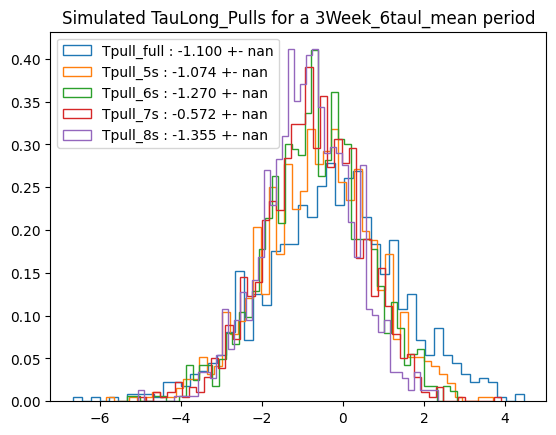

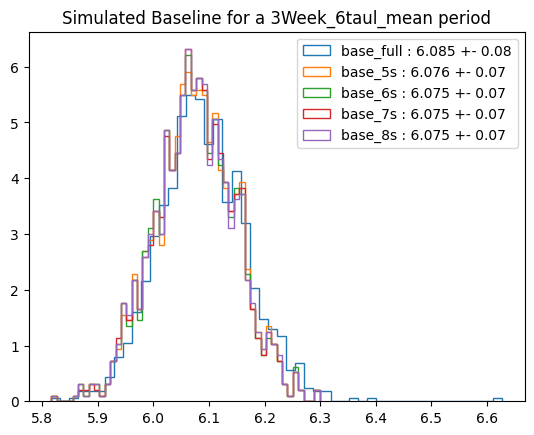

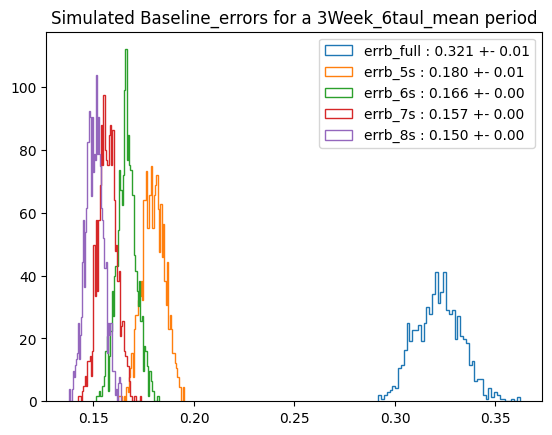

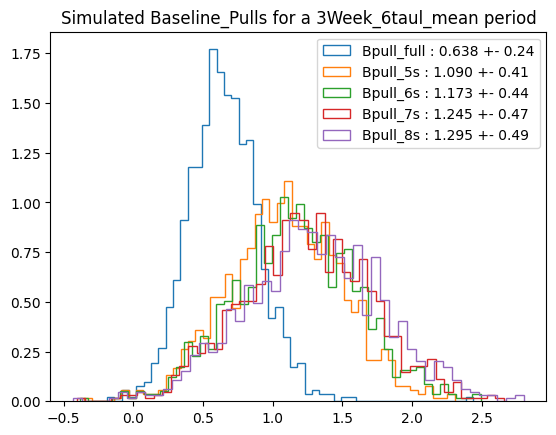

Values for simulated week of data taking at different cuts
Tau long estimation: 186.88671 +/- 0.42902
Tau long estimation: 186.10989 +/- 1.54432
Tau long estimation: 185.62187 +/- 2.05663
Tau long estimation: 185.00114 +/- 2.78794
Tau long estimation: 183.71780 +/- 3.82681
Baseline for simulated week of data taking at different cuts
Baseline estimation: 6.08485 +/- 0.32138
Baseline estimation: 6.07566 +/- 0.17974
Baseline estimation: 6.07480 +/- 0.16637
Baseline estimation: 6.07500 +/- 0.15677
Baseline estimation: 6.07463 +/- 0.15048


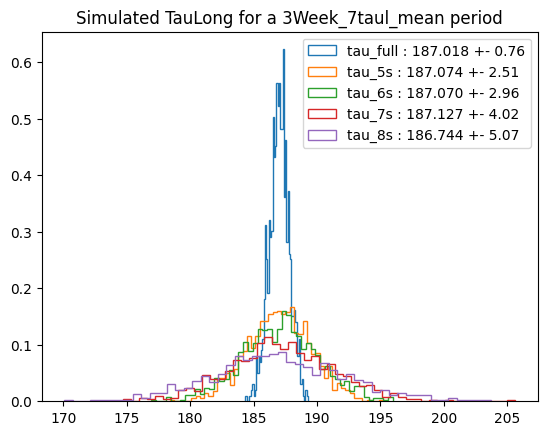

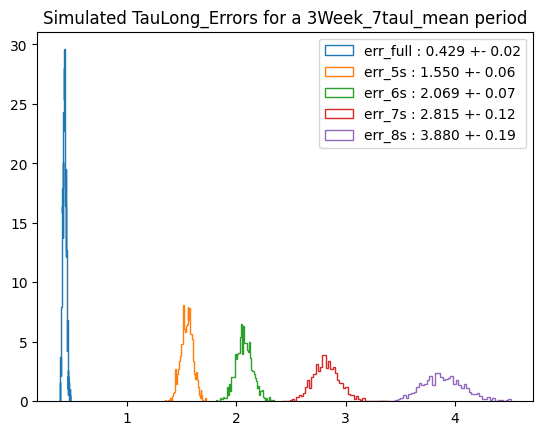

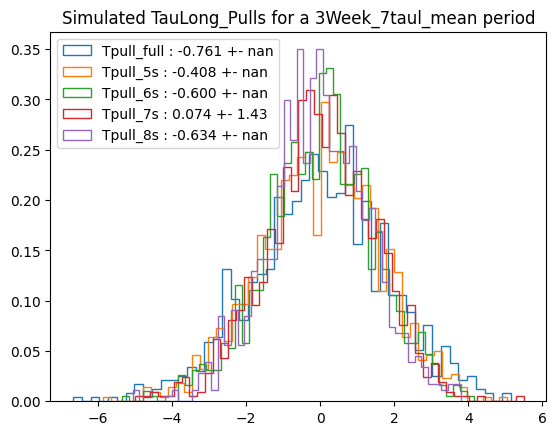

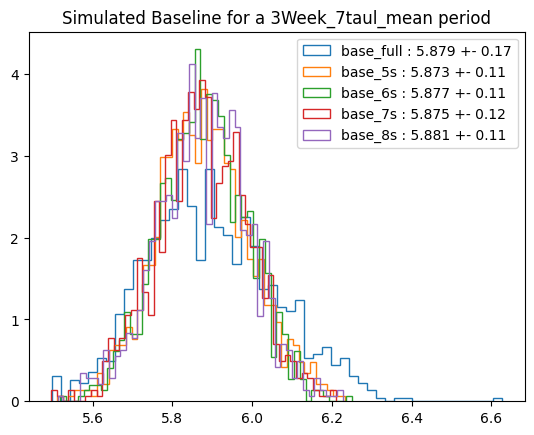

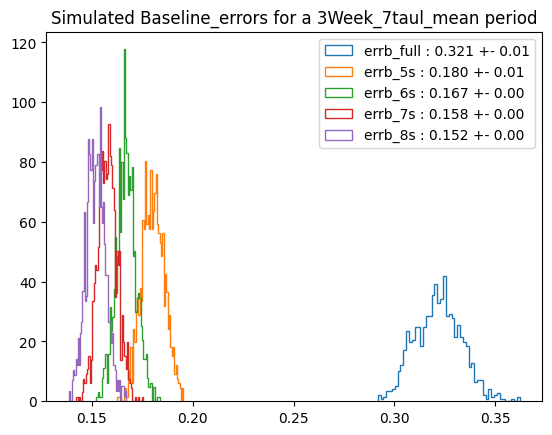

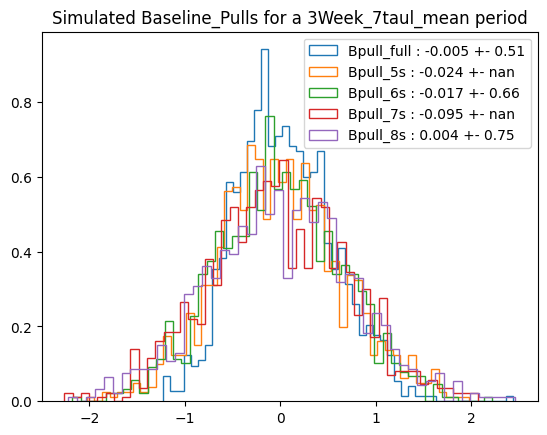

Values for simulated week of data taking at different cuts
Tau long estimation: 187.01782 +/- 0.42916
Tau long estimation: 187.07395 +/- 1.55000
Tau long estimation: 187.06961 +/- 2.06887
Tau long estimation: 187.12735 +/- 2.81463
Tau long estimation: 186.74443 +/- 3.87999
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.87854 +/- 0.32140
Baseline estimation: 5.87251 +/- 0.18010
Baseline estimation: 5.87741 +/- 0.16691
Baseline estimation: 5.87534 +/- 0.15766
Baseline estimation: 5.88131 +/- 0.15185


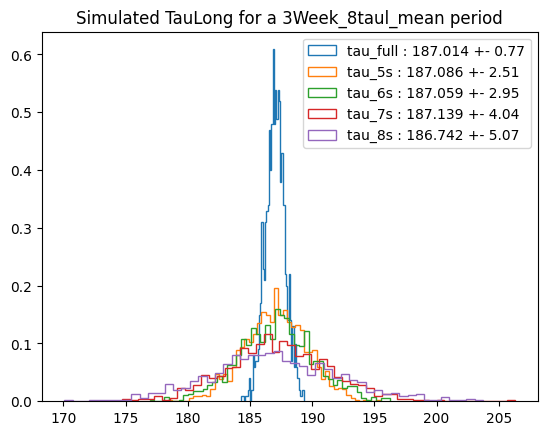

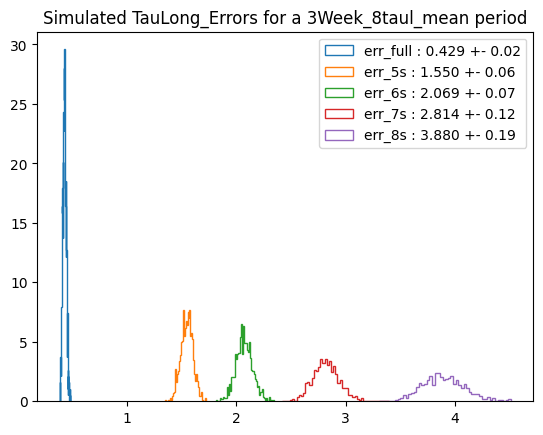

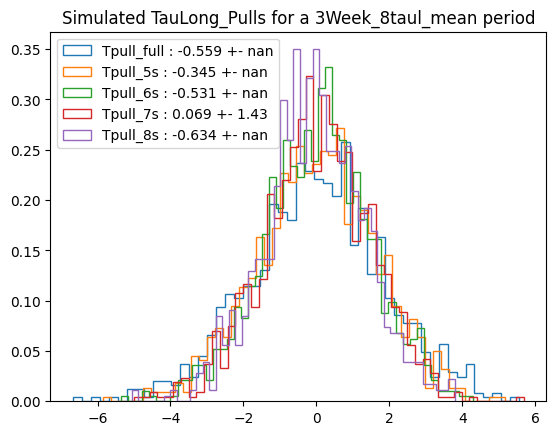

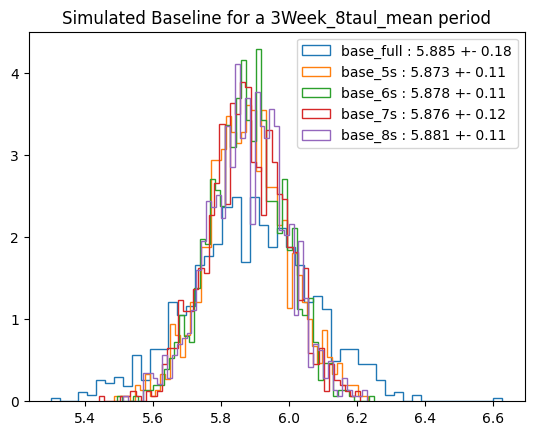

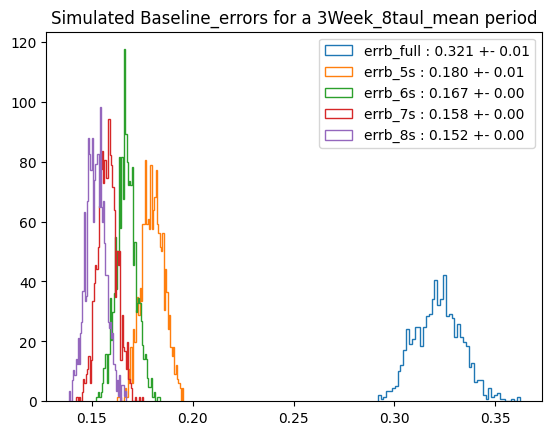

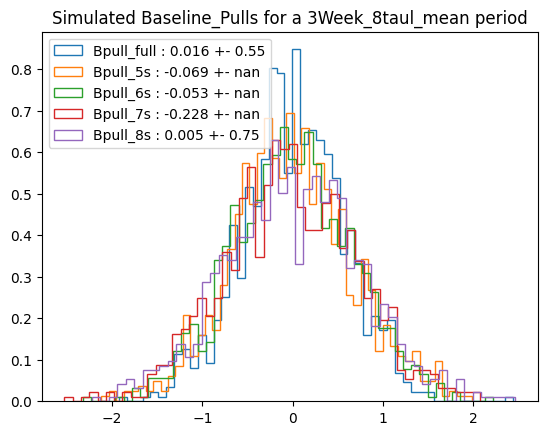

Values for simulated week of data taking at different cuts
Tau long estimation: 187.01429 +/- 0.42916
Tau long estimation: 187.08646 +/- 1.55003
Tau long estimation: 187.05892 +/- 2.06883
Tau long estimation: 187.13877 +/- 2.81438
Tau long estimation: 186.74245 +/- 3.87993
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.88523 +/- 0.32140
Baseline estimation: 5.87304 +/- 0.18011
Baseline estimation: 5.87769 +/- 0.16692
Baseline estimation: 5.87579 +/- 0.15766
Baseline estimation: 5.88138 +/- 0.15185


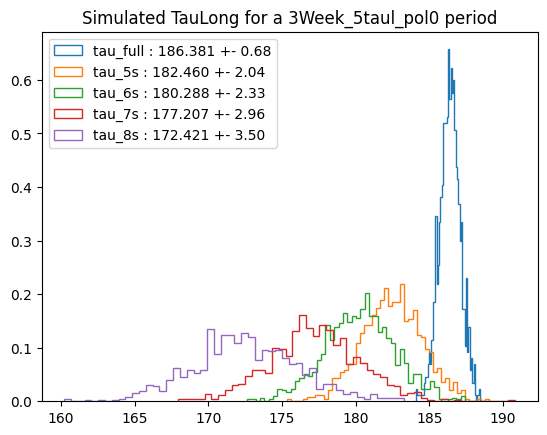

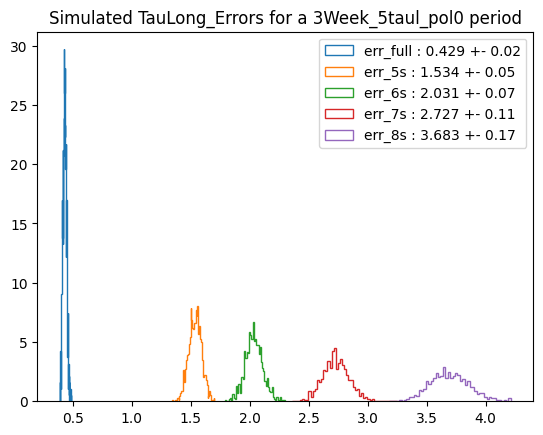

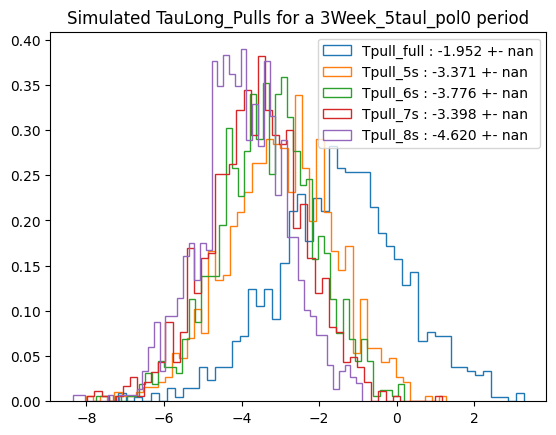

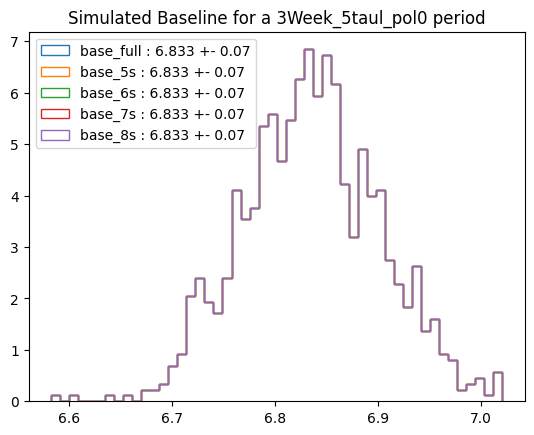

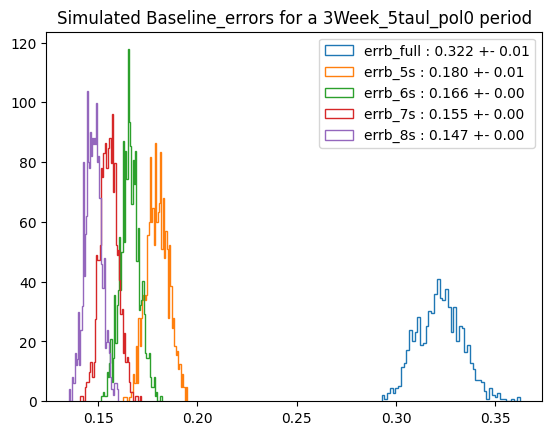

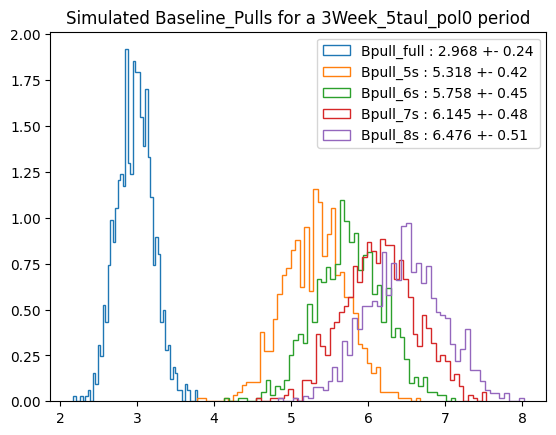

Values for simulated week of data taking at different cuts
Tau long estimation: 186.38090 +/- 0.42918
Tau long estimation: 182.45963 +/- 1.53448
Tau long estimation: 180.28772 +/- 2.03130
Tau long estimation: 177.20750 +/- 2.72709
Tau long estimation: 172.42083 +/- 3.68284
Baseline for simulated week of data taking at different cuts
Baseline estimation: 6.83334 +/- 0.32178
Baseline estimation: 6.83334 +/- 0.17976
Baseline estimation: 6.83334 +/- 0.16583
Baseline estimation: 6.83334 +/- 0.15527
Baseline estimation: 6.83334 +/- 0.14743


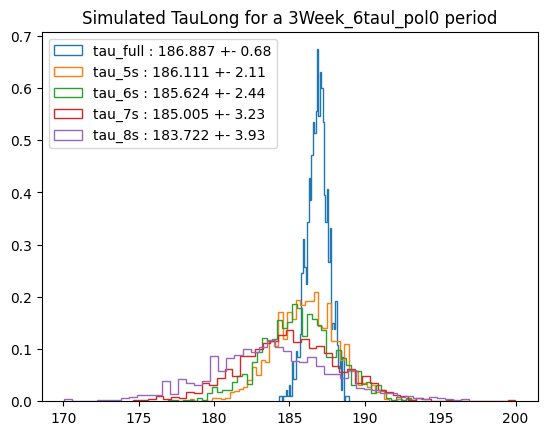

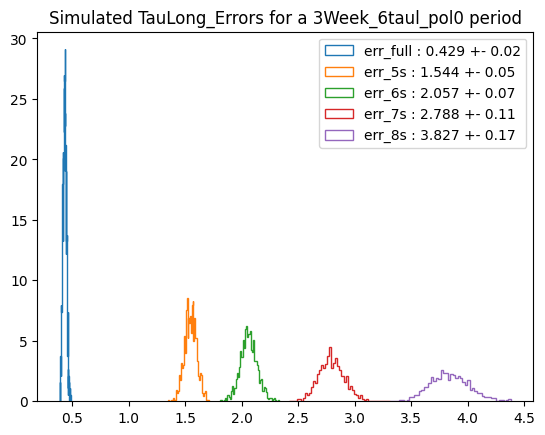

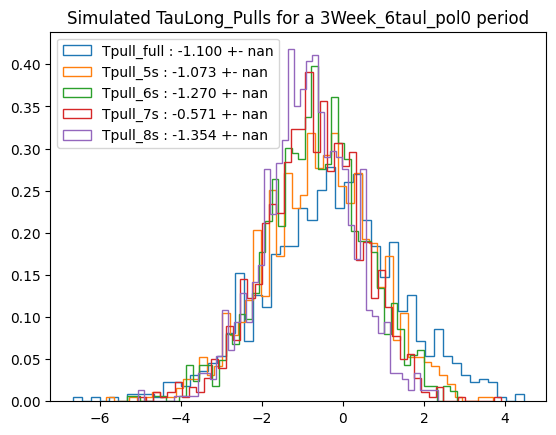

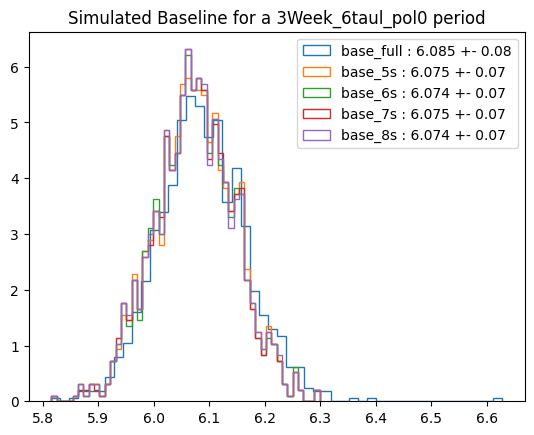

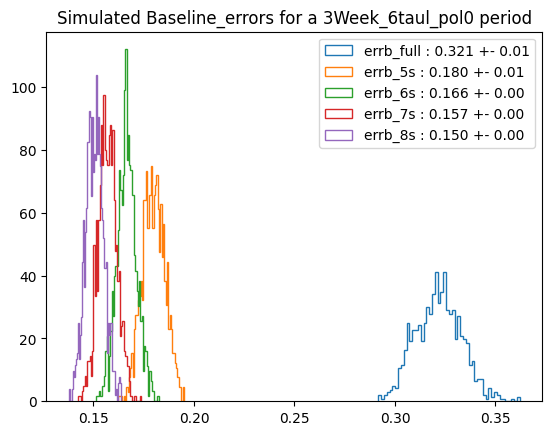

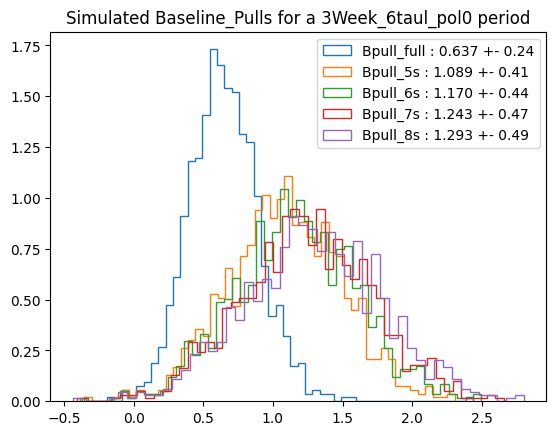

Values for simulated week of data taking at different cuts
Tau long estimation: 186.88683 +/- 0.42902
Tau long estimation: 186.11078 +/- 1.54433
Tau long estimation: 185.62425 +/- 2.05665
Tau long estimation: 185.00461 +/- 2.78796
Tau long estimation: 183.72197 +/- 3.82697
Baseline for simulated week of data taking at different cuts
Baseline estimation: 6.08470 +/- 0.32138
Baseline estimation: 6.07536 +/- 0.17974
Baseline estimation: 6.07447 +/- 0.16637
Baseline estimation: 6.07468 +/- 0.15677
Baseline estimation: 6.07431 +/- 0.15048


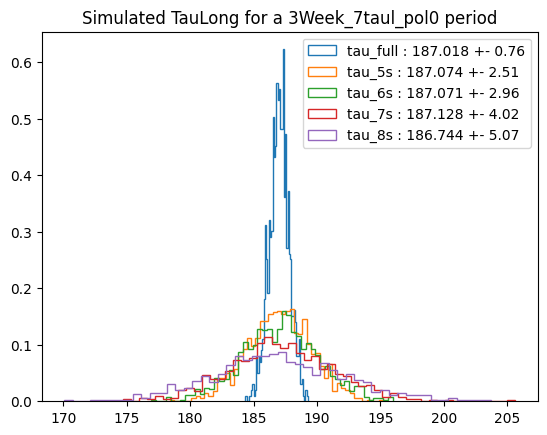

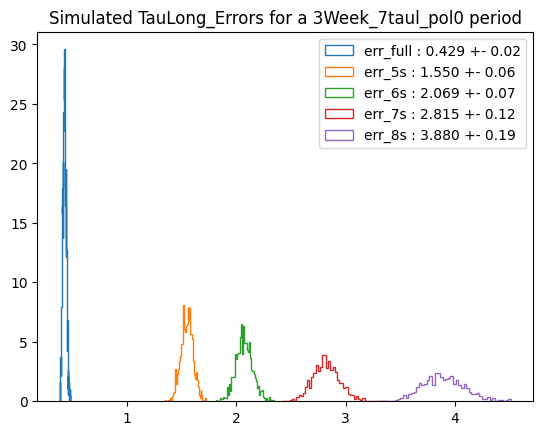

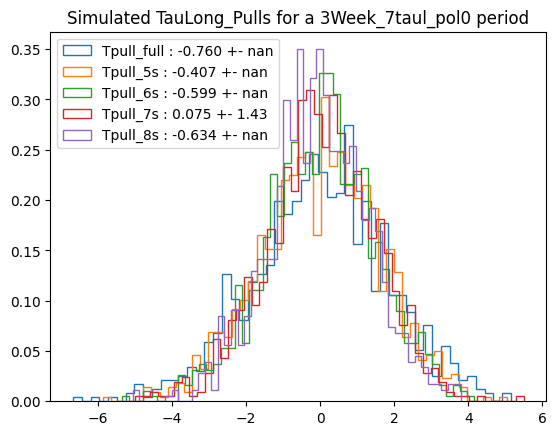

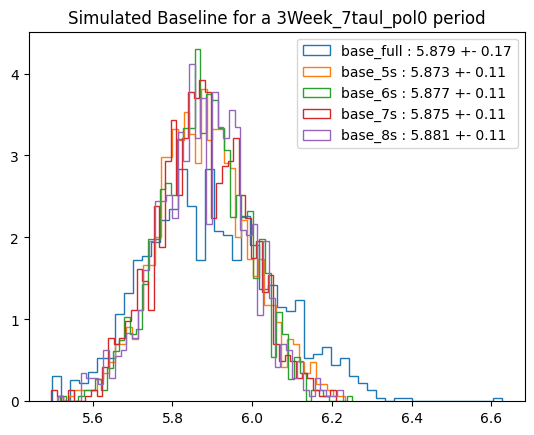

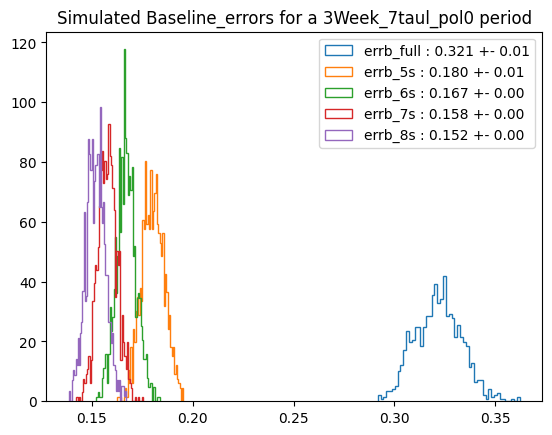

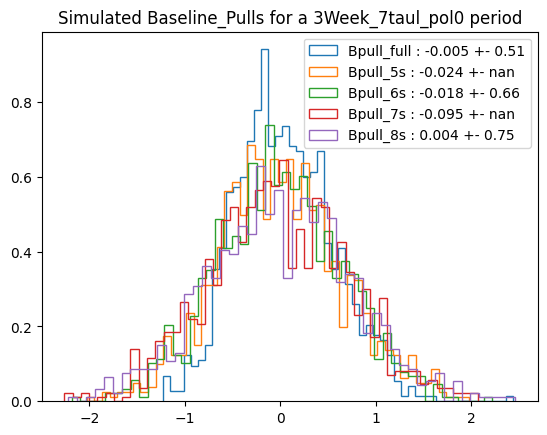

Values for simulated week of data taking at different cuts
Tau long estimation: 187.01762 +/- 0.42916
Tau long estimation: 187.07440 +/- 1.55001
Tau long estimation: 187.07114 +/- 2.06887
Tau long estimation: 187.12802 +/- 2.81460
Tau long estimation: 186.74443 +/- 3.87999
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.87866 +/- 0.32140
Baseline estimation: 5.87255 +/- 0.18010
Baseline estimation: 5.87737 +/- 0.16691
Baseline estimation: 5.87533 +/- 0.15766
Baseline estimation: 5.88131 +/- 0.15185


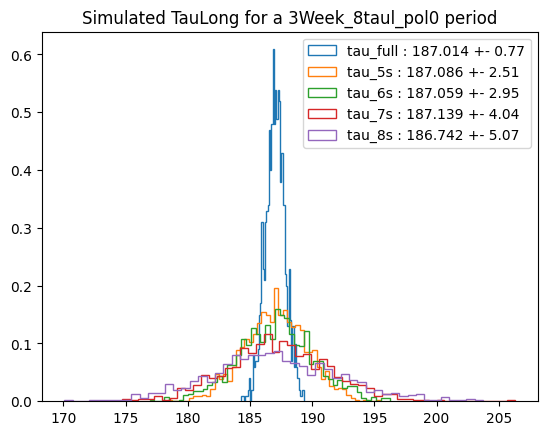

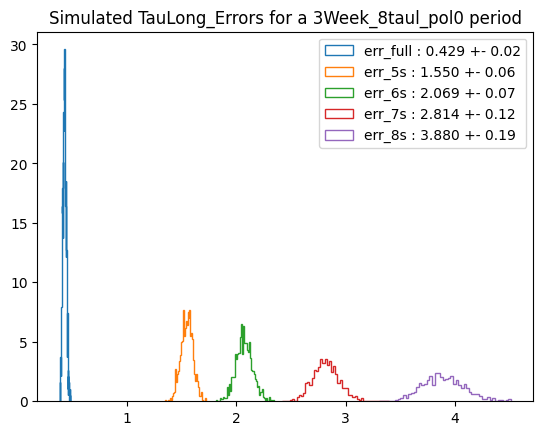

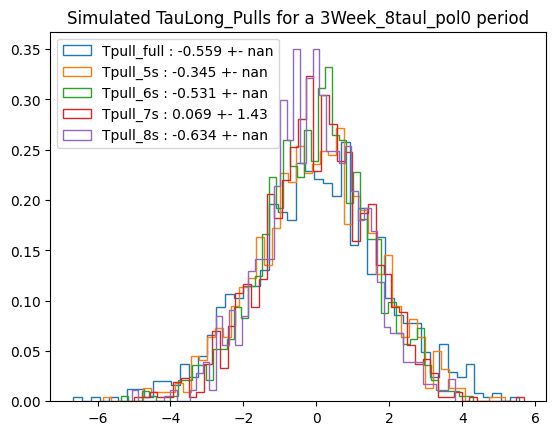

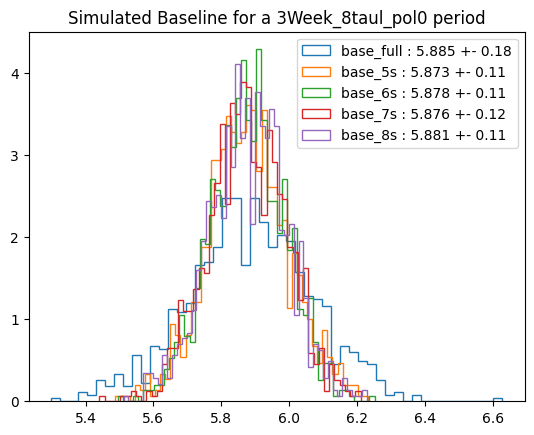

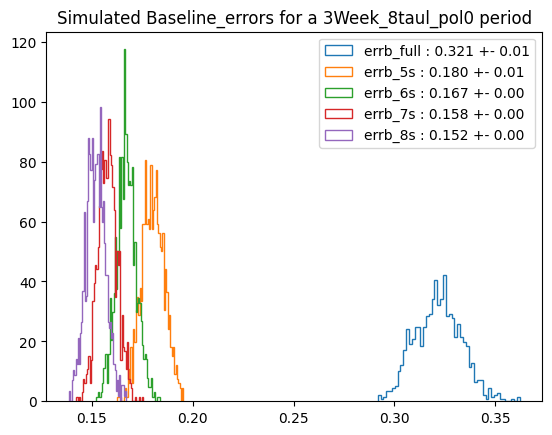

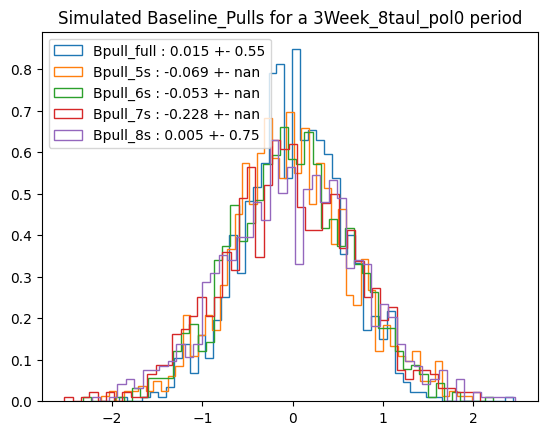

Values for simulated week of data taking at different cuts
Tau long estimation: 187.01418 +/- 0.42916
Tau long estimation: 187.08646 +/- 1.55003
Tau long estimation: 187.05892 +/- 2.06883
Tau long estimation: 187.13877 +/- 2.81438
Tau long estimation: 186.74245 +/- 3.87993
Baseline for simulated week of data taking at different cuts
Baseline estimation: 5.88508 +/- 0.32140
Baseline estimation: 5.87304 +/- 0.18011
Baseline estimation: 5.87769 +/- 0.16692
Baseline estimation: 5.87579 +/- 0.15766
Baseline estimation: 5.88138 +/- 0.15185


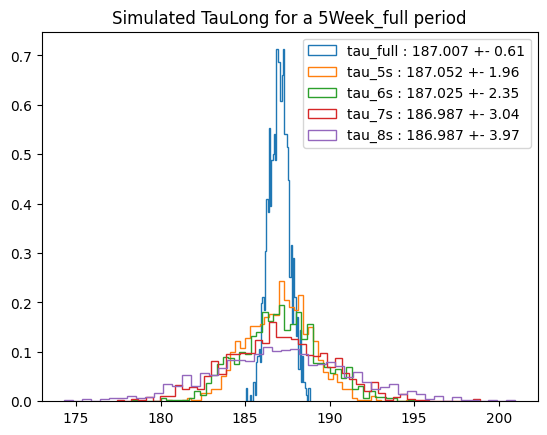

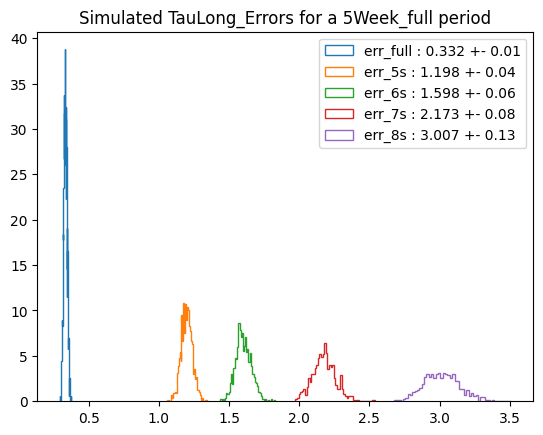

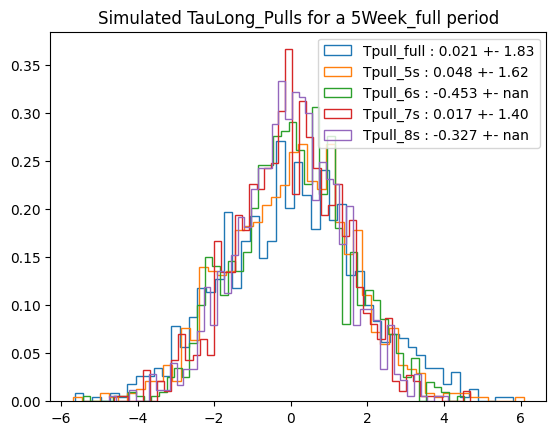

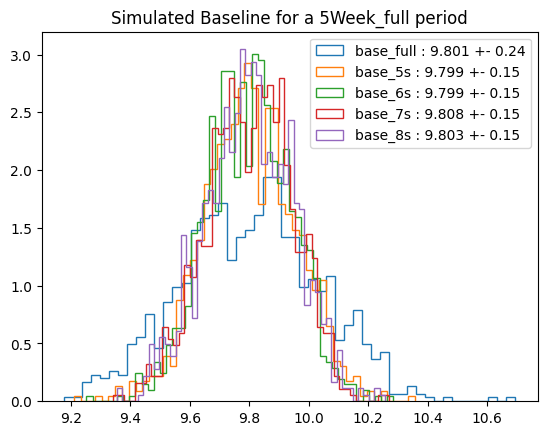

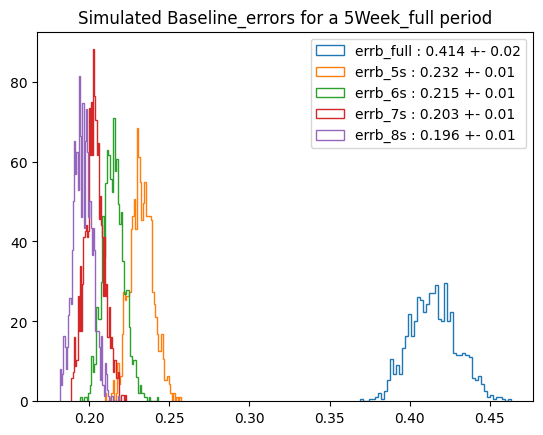

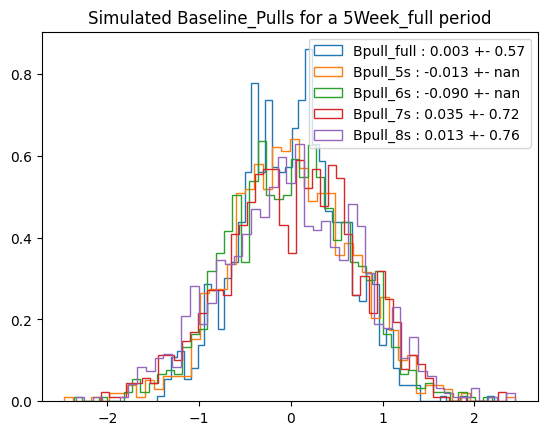

Values for simulated week of data taking at different cuts
Tau long estimation: 187.00714 +/- 0.33198
Tau long estimation: 187.05210 +/- 1.19777
Tau long estimation: 187.02534 +/- 1.59826
Tau long estimation: 186.98740 +/- 2.17251
Tau long estimation: 186.98712 +/- 3.00707
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.80104 +/- 0.41418
Baseline estimation: 9.79929 +/- 0.23217
Baseline estimation: 9.79859 +/- 0.21479
Baseline estimation: 9.80773 +/- 0.20286
Baseline estimation: 9.80312 +/- 0.19564


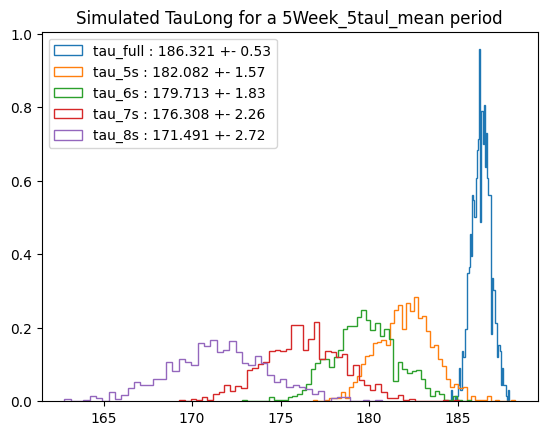

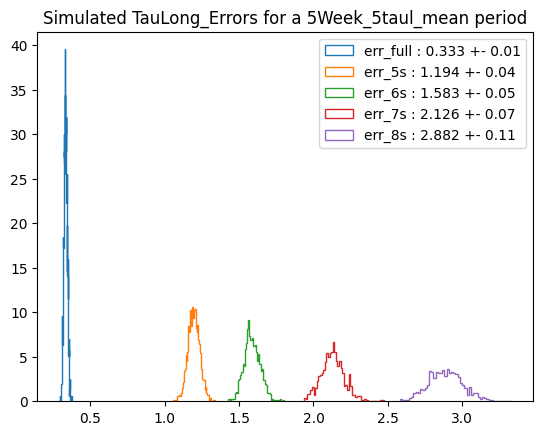

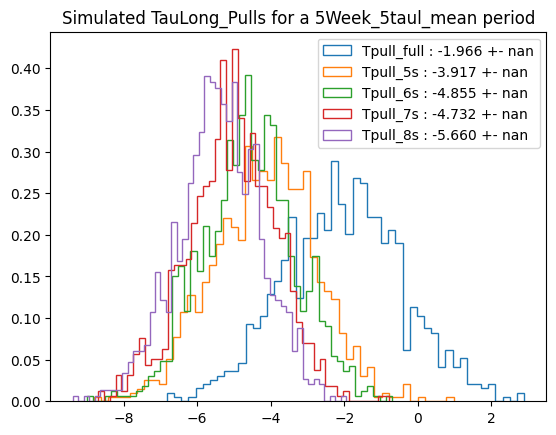

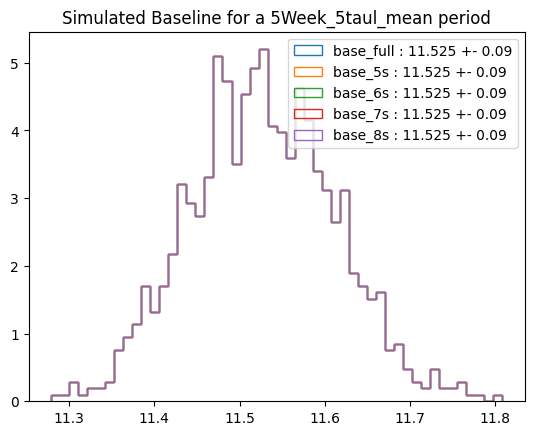

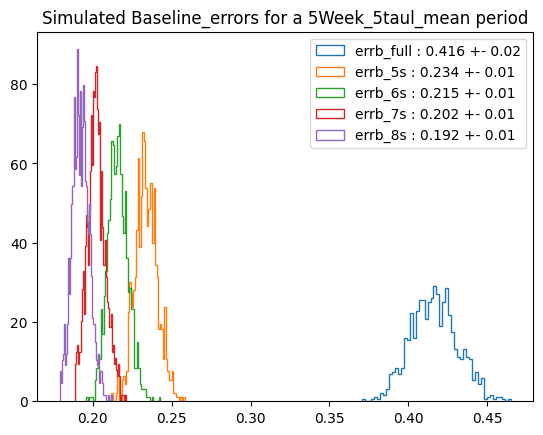

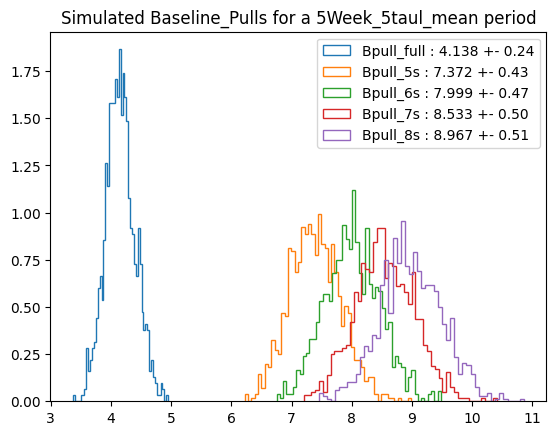

Values for simulated week of data taking at different cuts
Tau long estimation: 186.32090 +/- 0.33267
Tau long estimation: 182.08201 +/- 1.19432
Tau long estimation: 179.71327 +/- 1.58291
Tau long estimation: 176.30757 +/- 2.12555
Tau long estimation: 171.49113 +/- 2.88183
Baseline for simulated week of data taking at different cuts
Baseline estimation: 11.52506 +/- 0.41566
Baseline estimation: 11.52506 +/- 0.23355
Baseline estimation: 11.52506 +/- 0.21543
Baseline estimation: 11.52506 +/- 0.20199
Baseline estimation: 11.52506 +/- 0.19212


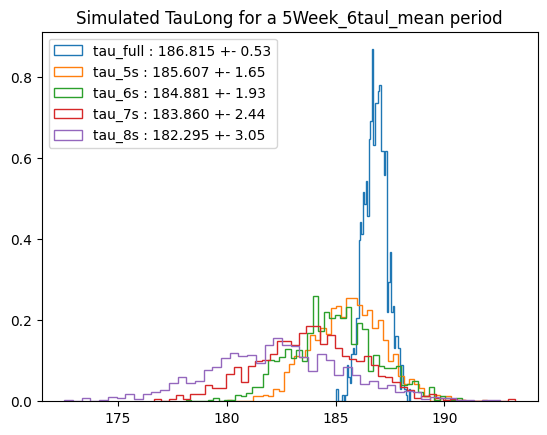

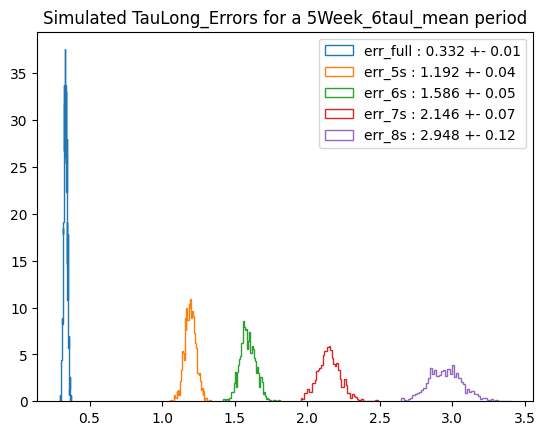

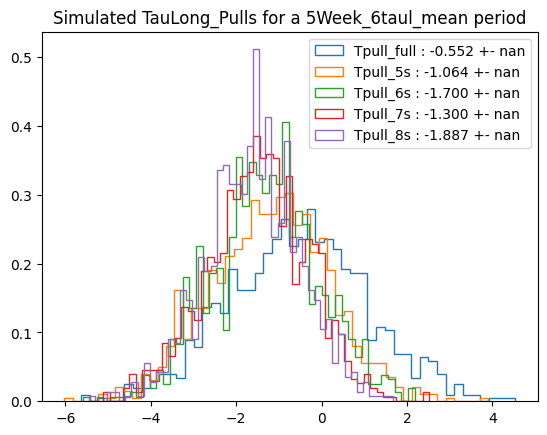

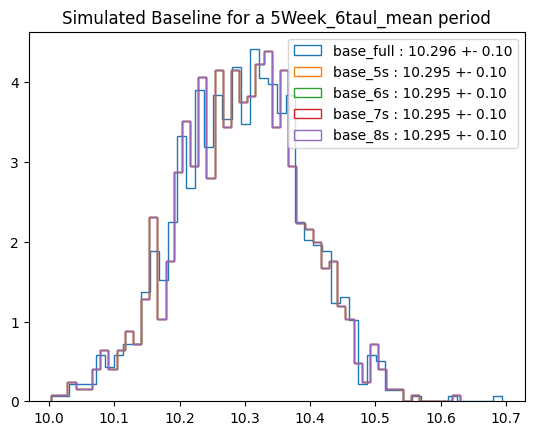

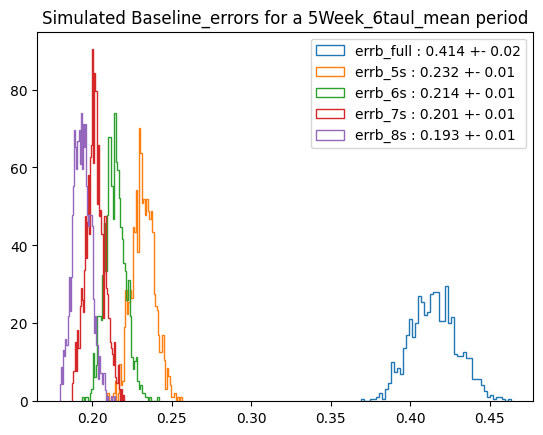

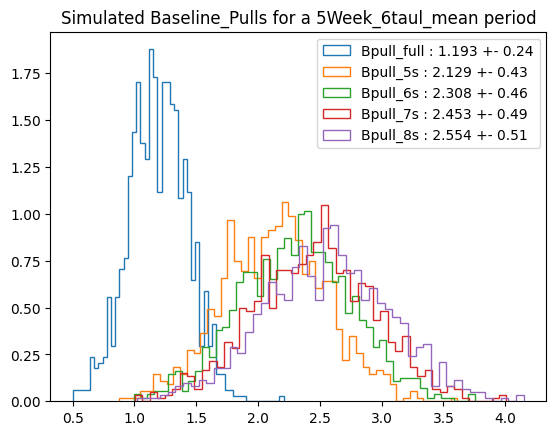

Values for simulated week of data taking at different cuts
Tau long estimation: 186.81452 +/- 0.33188
Tau long estimation: 185.60687 +/- 1.19236
Tau long estimation: 184.88062 +/- 1.58631
Tau long estimation: 183.85977 +/- 2.14607
Tau long estimation: 182.29519 +/- 2.94765
Baseline for simulated week of data taking at different cuts
Baseline estimation: 10.29603 +/- 0.41422
Baseline estimation: 10.29542 +/- 0.23172
Baseline estimation: 10.29542 +/- 0.21396
Baseline estimation: 10.29542 +/- 0.20142
Baseline estimation: 10.29542 +/- 0.19319


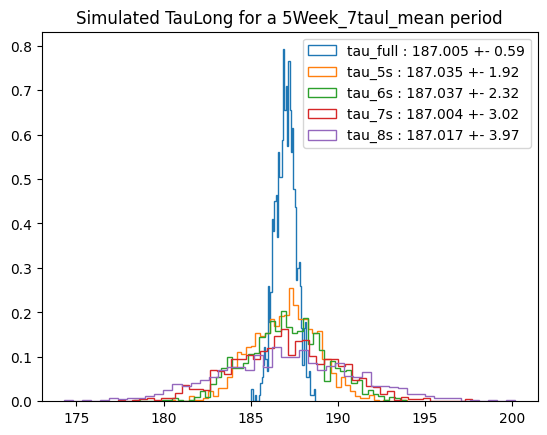

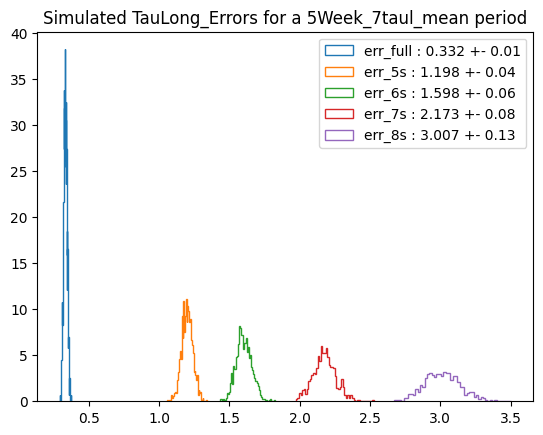

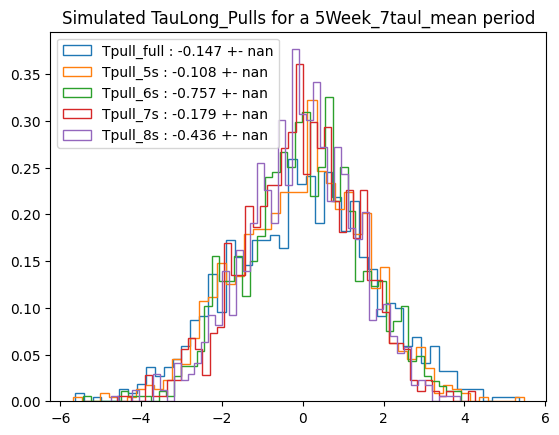

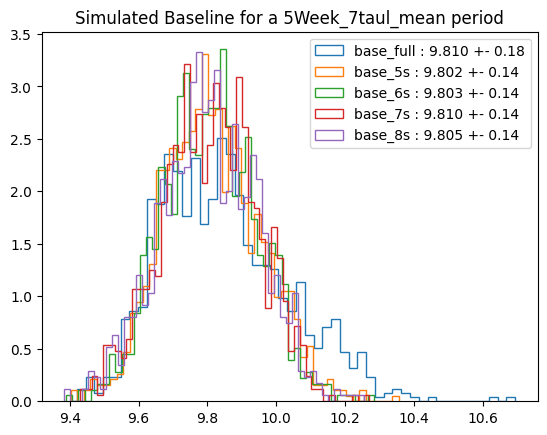

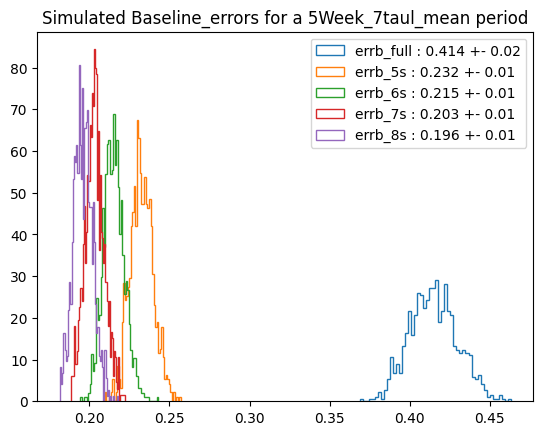

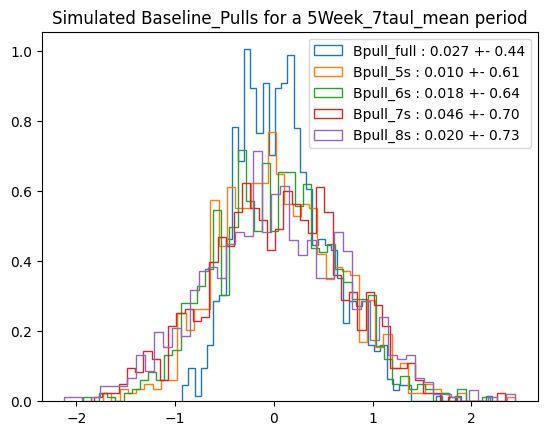

Values for simulated week of data taking at different cuts
Tau long estimation: 187.00510 +/- 0.33197
Tau long estimation: 187.03546 +/- 1.19768
Tau long estimation: 187.03718 +/- 1.59811
Tau long estimation: 187.00432 +/- 2.17281
Tau long estimation: 187.01737 +/- 3.00701
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.81016 +/- 0.41418
Baseline estimation: 9.80224 +/- 0.23214
Baseline estimation: 9.80332 +/- 0.21477
Baseline estimation: 9.80997 +/- 0.20287
Baseline estimation: 9.80506 +/- 0.19561


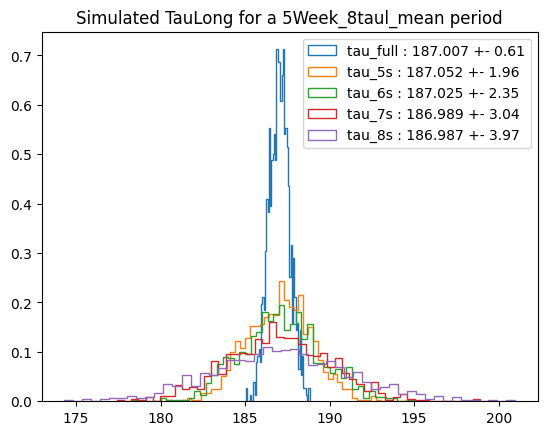

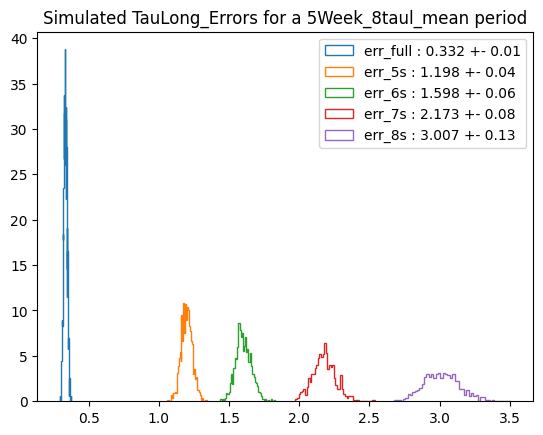

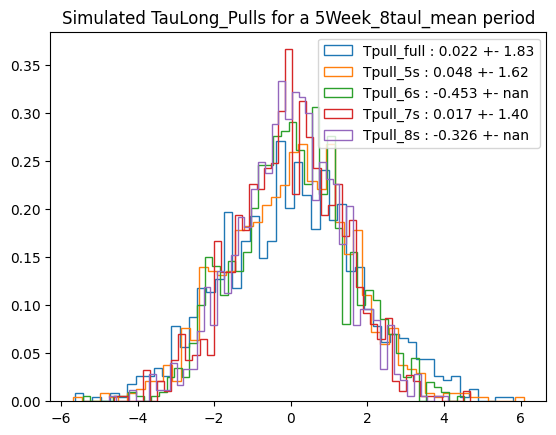

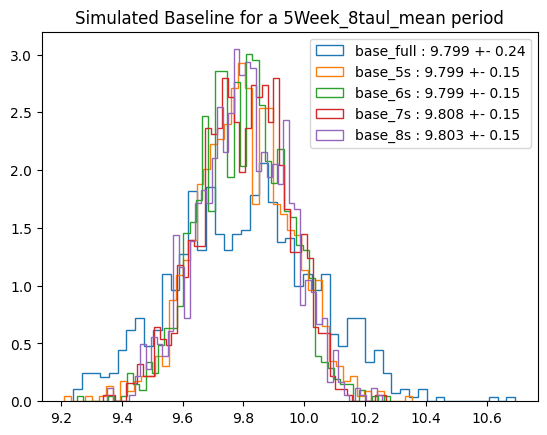

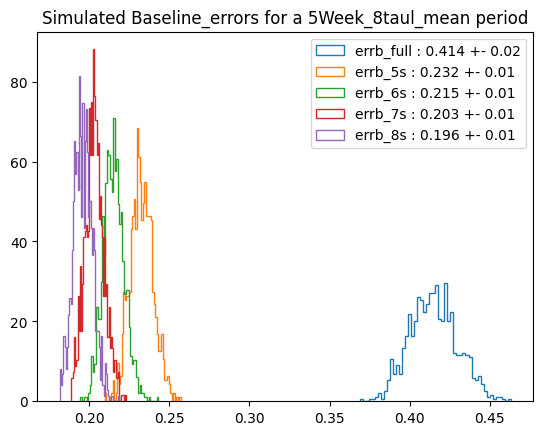

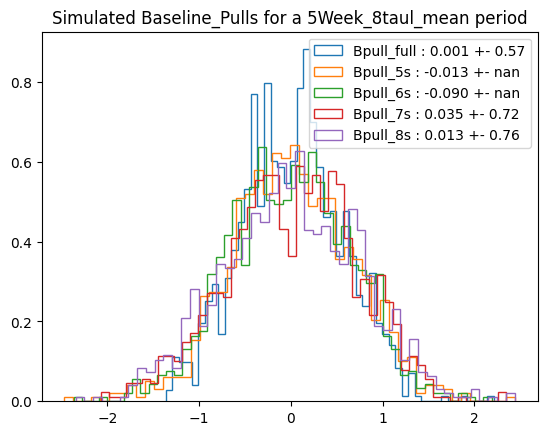

Values for simulated week of data taking at different cuts
Tau long estimation: 187.00727 +/- 0.33198
Tau long estimation: 187.05214 +/- 1.19777
Tau long estimation: 187.02528 +/- 1.59826
Tau long estimation: 186.98931 +/- 2.17251
Tau long estimation: 186.98691 +/- 3.00707
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.79937 +/- 0.41418
Baseline estimation: 9.79928 +/- 0.23217
Baseline estimation: 9.79860 +/- 0.21479
Baseline estimation: 9.80773 +/- 0.20286
Baseline estimation: 9.80310 +/- 0.19564


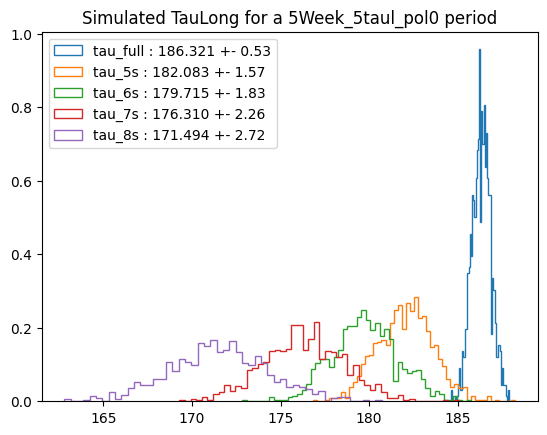

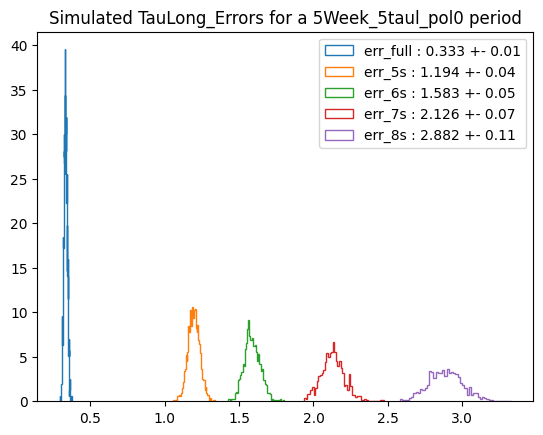

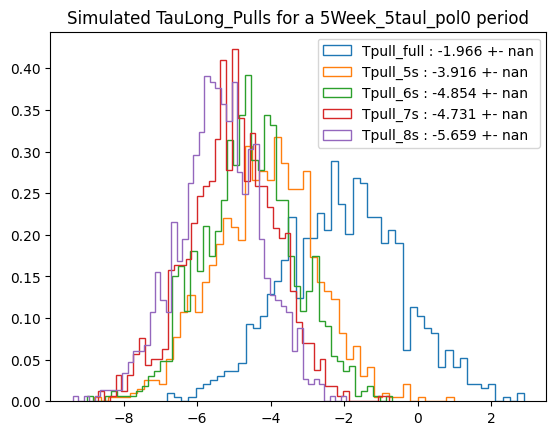

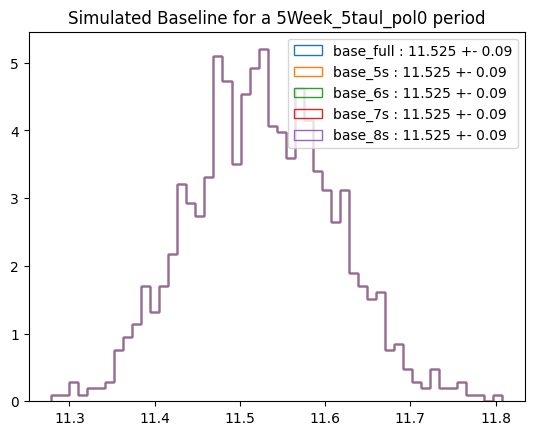

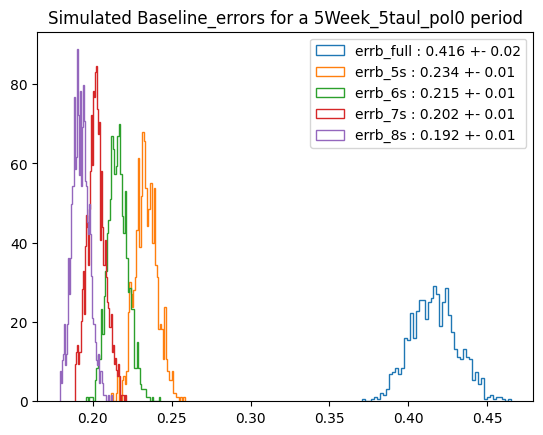

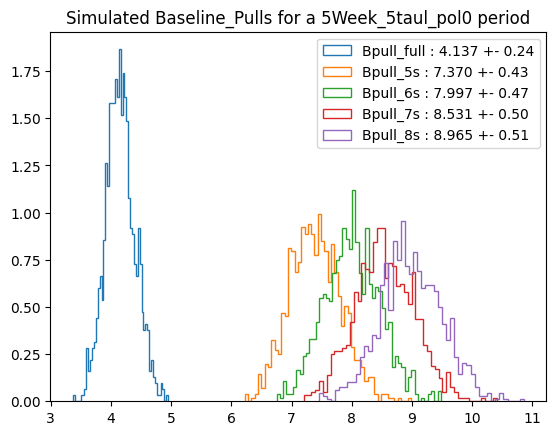

Values for simulated week of data taking at different cuts
Tau long estimation: 186.32106 +/- 0.33266
Tau long estimation: 182.08312 +/- 1.19431
Tau long estimation: 179.71492 +/- 1.58291
Tau long estimation: 176.30999 +/- 2.12554
Tau long estimation: 171.49447 +/- 2.88184
Baseline for simulated week of data taking at different cuts
Baseline estimation: 11.52466 +/- 0.41566
Baseline estimation: 11.52466 +/- 0.23354
Baseline estimation: 11.52466 +/- 0.21543
Baseline estimation: 11.52466 +/- 0.20199
Baseline estimation: 11.52466 +/- 0.19212


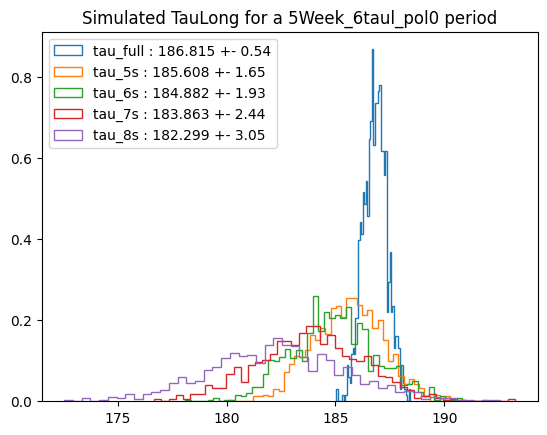

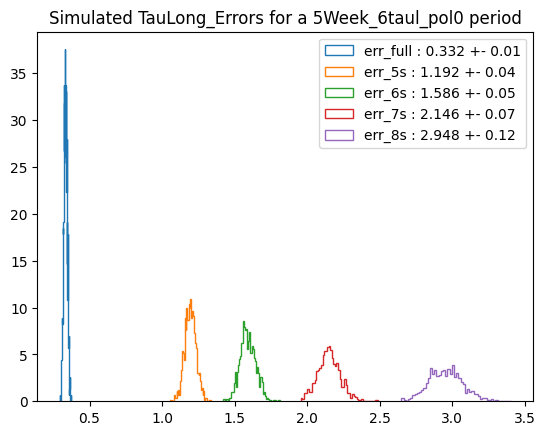

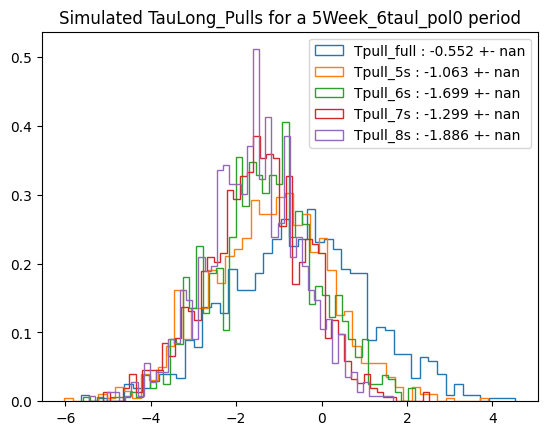

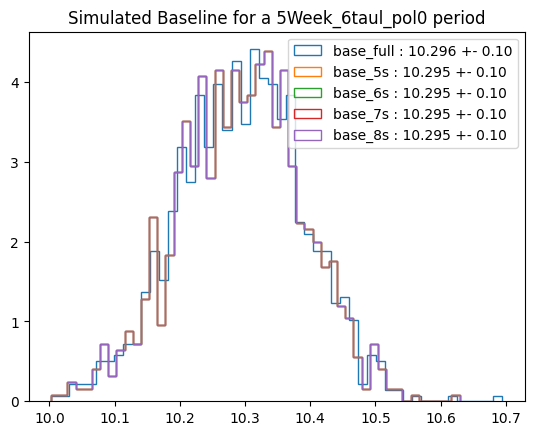

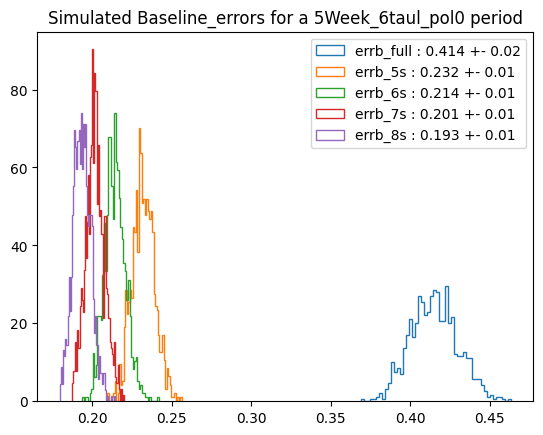

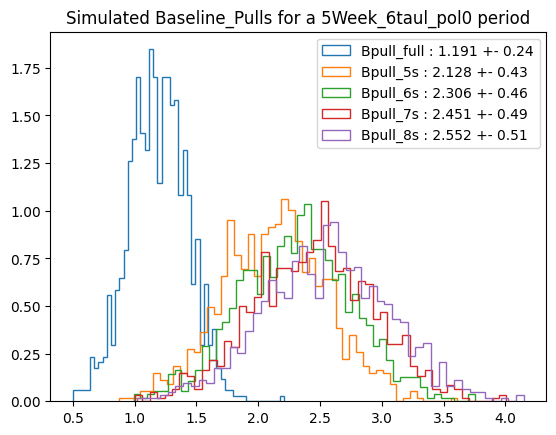

Values for simulated week of data taking at different cuts
Tau long estimation: 186.81461 +/- 0.33188
Tau long estimation: 185.60810 +/- 1.19236
Tau long estimation: 184.88246 +/- 1.58632
Tau long estimation: 183.86252 +/- 2.14609
Tau long estimation: 182.29916 +/- 2.94769
Baseline for simulated week of data taking at different cuts
Baseline estimation: 10.29553 +/- 0.41422
Baseline estimation: 10.29502 +/- 0.23172
Baseline estimation: 10.29502 +/- 0.21396
Baseline estimation: 10.29502 +/- 0.20142
Baseline estimation: 10.29502 +/- 0.19319


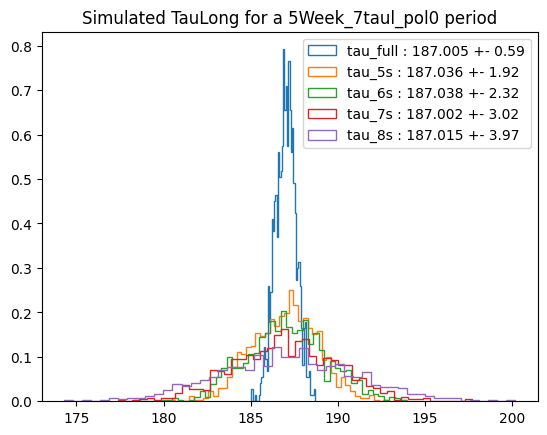

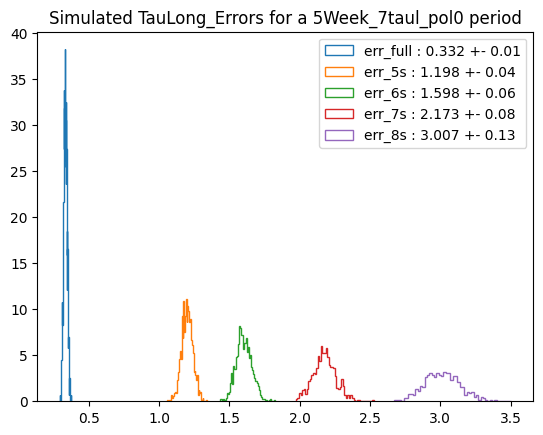

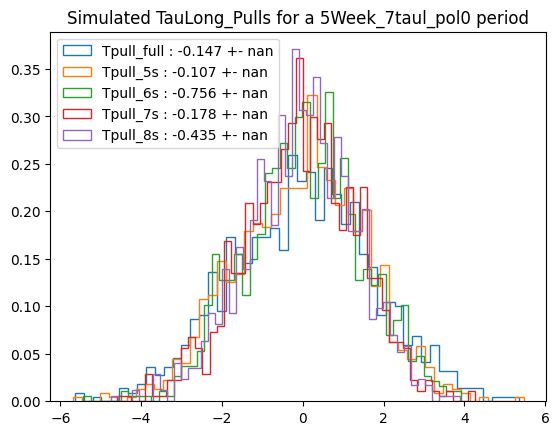

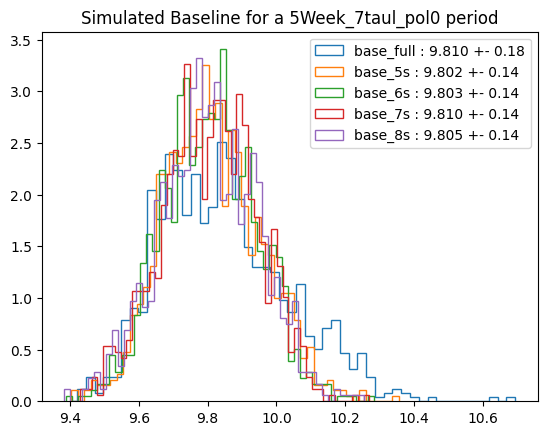

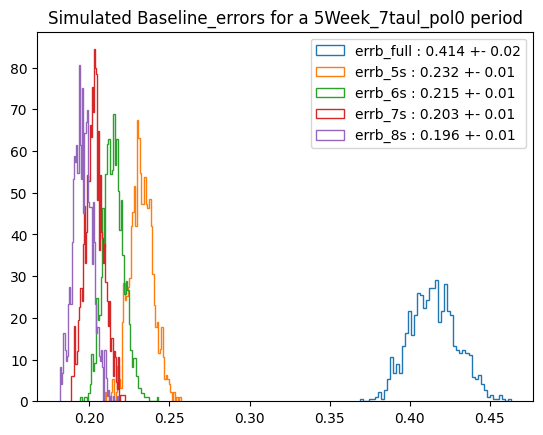

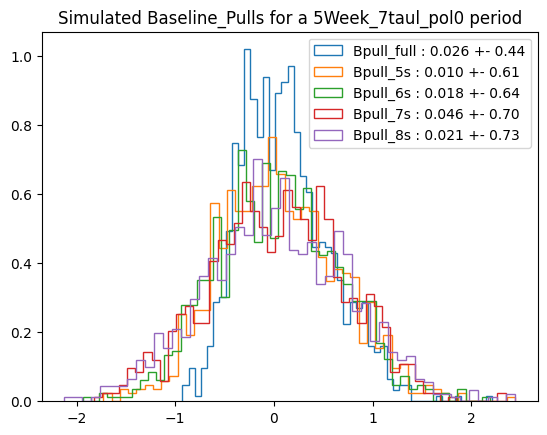

Values for simulated week of data taking at different cuts
Tau long estimation: 187.00502 +/- 0.33197
Tau long estimation: 187.03568 +/- 1.19768
Tau long estimation: 187.03803 +/- 1.59811
Tau long estimation: 187.00215 +/- 2.17284
Tau long estimation: 187.01462 +/- 3.00701
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.80981 +/- 0.41418
Baseline estimation: 9.80209 +/- 0.23214
Baseline estimation: 9.80314 +/- 0.21477
Baseline estimation: 9.80994 +/- 0.20287
Baseline estimation: 9.80472 +/- 0.19561


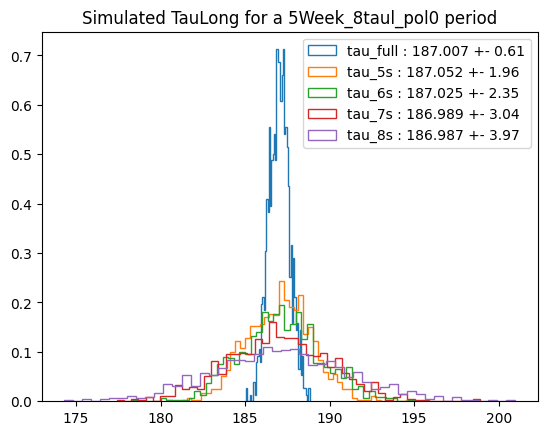

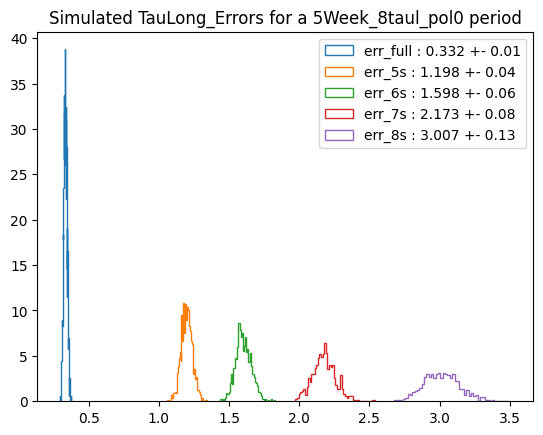

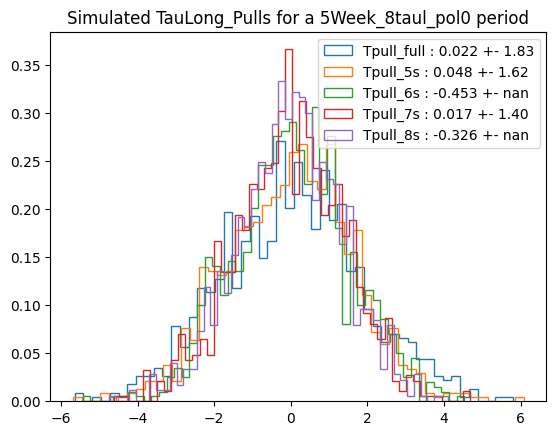

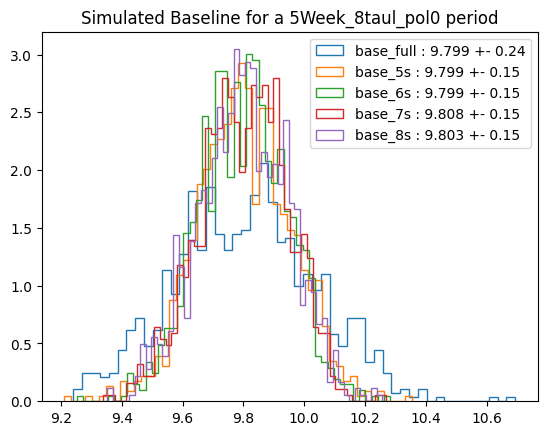

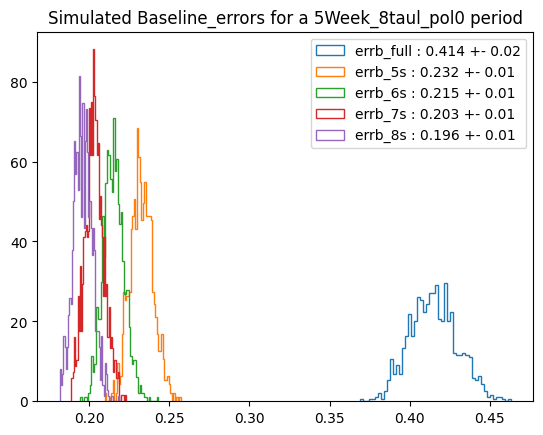

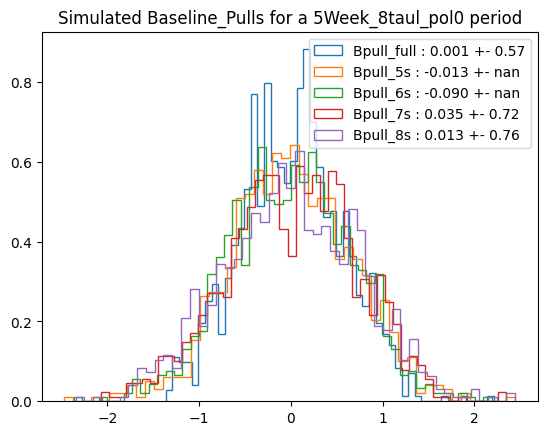

Values for simulated week of data taking at different cuts
Tau long estimation: 187.00727 +/- 0.33198
Tau long estimation: 187.05214 +/- 1.19777
Tau long estimation: 187.02528 +/- 1.59826
Tau long estimation: 186.98931 +/- 2.17251
Tau long estimation: 186.98691 +/- 3.00707
Baseline for simulated week of data taking at different cuts
Baseline estimation: 9.79937 +/- 0.41418
Baseline estimation: 9.79928 +/- 0.23217
Baseline estimation: 9.79860 +/- 0.21479
Baseline estimation: 9.80773 +/- 0.20286
Baseline estimation: 9.80310 +/- 0.19564


In [ ]:
#run for all dataframes
for data, weeks in zip ([stats_week,stats_3week,stats_5week], ["1Week","3Week","5Week"]):
  for df,name in zip(data, strings):
    time,error,pull,basel,baserr,basepull = plotter(df, "%s_%s"%(weeks,name) ,"yes")
    printer =["Tau long estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(time, error) ]
    print("Values for simulated week of data taking at different cuts")
    for i in printer:
      print(i)
    print("Baseline for simulated week of data taking at different cuts")
    printer =["Baseline estimation: %.5f +/- %.5f" %(i,j) for i,j in zip(basel, baserr) ]
    for i in printer:
      print(i)